# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


ЦЕЛЬ 
- Целью работы является моделирование оттока клиентов с помощью методов машинного обучения. Результаты в дальнейшем могут использоваться для выявления группы клиентов, к которым необходим специальный подход: коммуникации на удержание, повышение лояльности, исключение из целевых групп для продажи дополнительных продуктов.

ЗАДАЧИ
- изучение данных
- первичная подготовка данных
- иследовательский анализ данных 
- предмодельная подготовка данных 
- обучение моделей
- анализ лучшей модели

план работы: 
1. изучение данных 
- чтение всех файлов
- анализ contract
- анализ personal
- анализ internet
- анализ phone
2. подготовка данных 
- выделение целевого признака и дополнительных признаков 
- преобразование типов данных
- работа с пропусками
- объединение данных 
3. иследовательский анализ данных 
- распределение признаков
- детальное изучение признаков
- выводы по анализу
4. предмодельная подготовка 
- корреляционный анализ признаков
- доработка признаков 
- оценка и балансировка классов
- кодировка признаков
5. моделирование
- CatBoostClassifier
- LogisticRegression
6. оценка модели 
- проверка на тестовой выборке 
- матрица ошибок 
- анализ важности признаков 
7. выводы 

# Описание данных

Данные состоят из файлов, полученных из разных источников:
- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

In [1]:
pip install phik

     |████████████████████████████████| 679 kB 1.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install optuna

     |████████████████████████████████| 404 kB 1.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap

     |████████████████████████████████| 547 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [98]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline, make_pipeline, make_union
from sklearn.compose import make_column_transformer,ColumnTransformer 
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
import catboost as cat
from catboost import Pool, cv
from sklearn.metrics import roc_auc_score, roc_curve
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


In [5]:
random_state = 70823

## ИЗУЧЕНИЕ ДАННЫХ 

In [6]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

создадим функция для анализа df

In [7]:
def analyze(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    df.info()

### contract

In [8]:
analyze(contract)

Количество стобцов: 8
Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


переименнуем customerID в СustomerID

In [9]:
contract = contract.rename(columns={'customerID': 'CustomerID'})
print(contract.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']


- BeginDate и EndDate имеют тип object, посморим далее, нужно ли нам изменить его на дату
- TotalCharges точно нужно привести к числовому типу 
- стоит сразу отметить, что EndDate послужит нам целевым признаком (если в столбце есть дата, значит человек ушел)
- В данных нет пропусков

однако сначала посмотрим на другие данные 

### personal

In [10]:
analyze(personal)

Количество стобцов: 5
Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
personal = personal.rename(columns={'gender': 'Gender'})
personal = personal.rename(columns={'customerID': 'CustomerID'})
print(personal.columns.values)

['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']


- В данных нет пропусков

###  internet

In [12]:
analyze(internet)

Количество стобцов: 8
Количество строк: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [13]:
internet = internet.rename(columns={'customerID': 'CustomerID'})
print(internet.columns.values)

['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']


- В данных нет пропусков
- Замечам, что строк здесь меньше, чем в предыдущих файлах, в дальнейшем попробуем разобраться с этим

###  phone

In [14]:
analyze(phone)

Количество стобцов: 2
Количество строк: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [15]:
phone = phone.rename(columns={'customerID': 'CustomerID'})
print(phone.columns.values)

['CustomerID' 'MultipleLines']


- В данных нет пропусков
- Так же, как и в предыдущем файле, тут меньше строк 

## подготовка данных  

###  выделение целевого признака и дополнительных признаков


просмотрел все файлы, можно начинать основную подготовку 

- создадим целевой признак на основе столбца EndDate

In [16]:

contract['Outflow'] = (contract['EndDate'] != 'No').astype(int)
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


забегая вперед стоит сказать, что при обучении модели нам придется избавится от столбцов с датами, однако что бы не терять информацию о периоде взаимодейсвия клиента с оператором, создадим отдельный признак `Period`

Заменим все значения "No" в EndDate на дату выгрузки датасета (01.02.2020)

In [17]:
contract['EndDate'] = contract['EndDate'].replace(['No'], ['2020-02-01'])
print(contract[contract['EndDate'] == 'No'].shape[0])

0


Переведем EndDate и BeginDate в формат даты

In [18]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')
contract.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Outflow           7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Создадим новый столбец Period, который будет показывать, сколько пользователь пользовался услугами оператора

In [19]:
contract['Period'] = (contract['EndDate'] - contract['BeginDate']).dt.days
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow,Period
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


### приведение к нужному типу данных

приведем столбец TotalCharges к числовому типу

In [20]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors ='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Outflow           7043 non-null   int64         
 9   Period            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


в TotalCharges появились пропуски, взглянем на них поближе 

### работа с пропусками 

In [21]:
contract[contract['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow,Period
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


можно заметить, что все клиенты, у которых нет оплаты, зарегестрировались в последний день т.е. только что, и скорее всего они еще не успели ничего купить, поэтому мы ставим вместо пропусков значение 0 

In [22]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
contract['TotalCharges'].isnull().sum()

0

проверим, нет ли повторяющихся ID: вдруг клиент поменял тариф, способ обплаты, и ему присвоили тот же ID

In [23]:
contract.nunique() 

CustomerID          7043
BeginDate             77
EndDate               67
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6658
Outflow                2
Period               251
dtype: int64

### объединение данных

In [24]:
Outflow_df = contract \
    .merge(personal, how='left', on='CustomerID') \
    .merge(internet, how='left', on='CustomerID') \
    .merge(phone, how='left', on='CustomerID')

# проверяем на уникальность значений столбца CustomerID
print(Outflow_df['CustomerID'].is_unique)

# установим CustomerID в качестве индекса
Outflow_df = Outflow_df.set_index('CustomerID')

# выводим анализ датафрейма
analyze(Outflow_df)

True
Количество стобцов: 21
Количество строк: 7043


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Outflow,Period,Gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Outflow           7043 non-null   int64         
 8   Period            7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

просмотрев данные, можно сделать вывод, что пропуски в столбцах объясняються отсутсвием у клиента этой услуги (у кого то подключен интернет, у кого то телефон, у кого-то все вместе) 

поэтому вместо пропусков вставим значение "No" 

In [25]:
#for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
Outflow_df = Outflow_df.fillna('NotUsed')
    
Outflow_df.info()    

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Outflow           7043 non-null   int64         
 8   Period            7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

## Исследовательский анализ данных

### распределение признаков

посмотрим неприрывные переменные

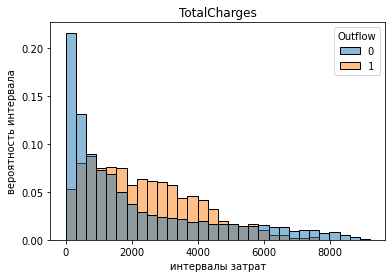

In [26]:
sns.histplot(data=Outflow_df,x="TotalCharges", hue = "Outflow",stat='probability',common_norm=False, bins = 30)\
   .set(xlabel ='интервалы затрат', ylabel='вероятность интервала')
plt.title('TotalCharges')
plt.rcParams["figure.figsize"] = (16,5)
plt.show()

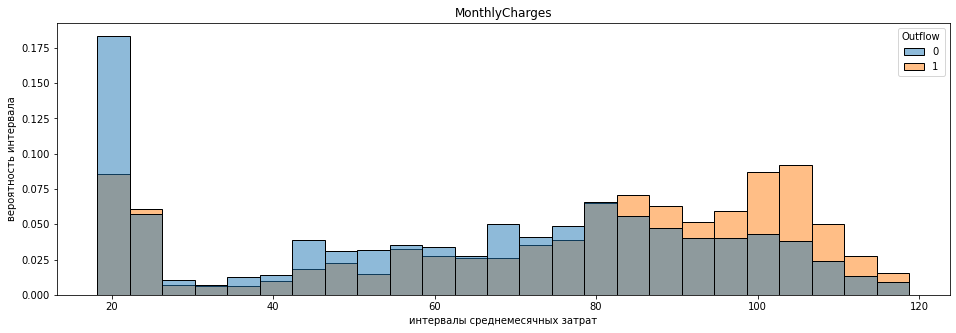

In [27]:
sns.histplot(data=Outflow_df,x="MonthlyCharges", hue = "Outflow",stat='probability',common_norm=False, bins = 25)\
   .set(xlabel ='интервалы среднемесячных затрат', ylabel='вероятность интервала')
plt.title('MonthlyCharges')
plt.rcParams["figure.figsize"] = (16,5)
plt.show()

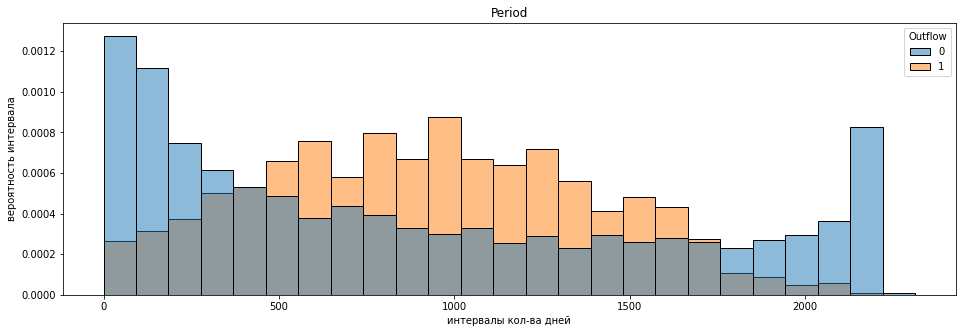

In [28]:
sns.histplot(data=Outflow_df,x="Period", hue = "Outflow",stat='density',common_norm=False, bins = 25)\
   .set(xlabel ='интервалы кол-ва дней', ylabel='вероятность интервала')
plt.title('Period')
plt.rcParams["figure.figsize"] = (16,5)
plt.show()

посмотрим на графиках как распределялись оставшиеся и ушедшие с сервиса пользователи относительно других признаков

In [32]:
column = ['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Period',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [33]:
def hist(column):
    plt.hist([Outflow_df[Outflow_df.Outflow == 1][column], Outflow_df[Outflow_df.Outflow == 0][column]], label=['Ушедшие', 'Оставшиеся'], density=True);
    plt.legend();
    plt.title(column);
    plt.show();

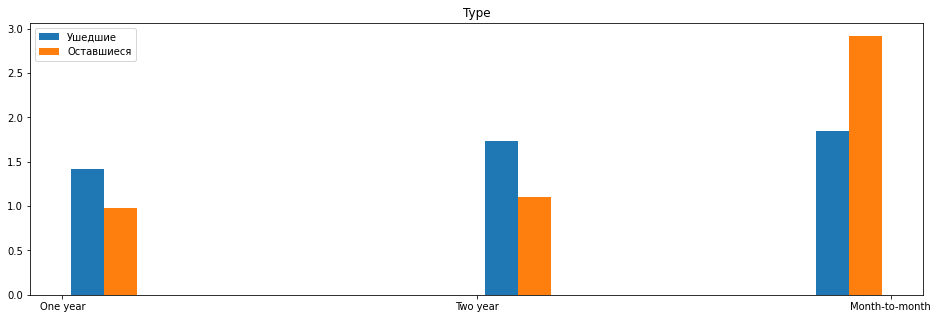

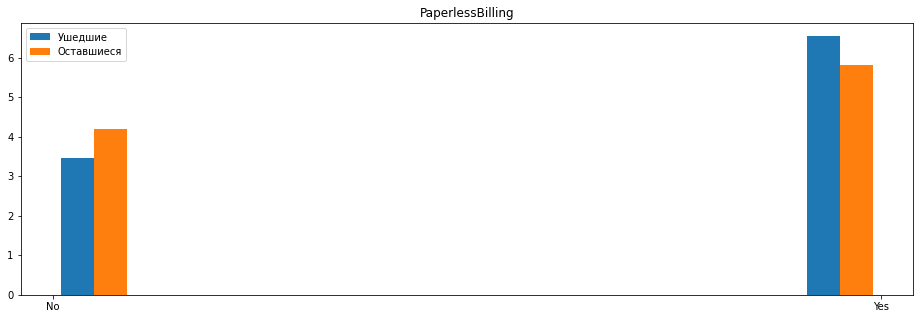

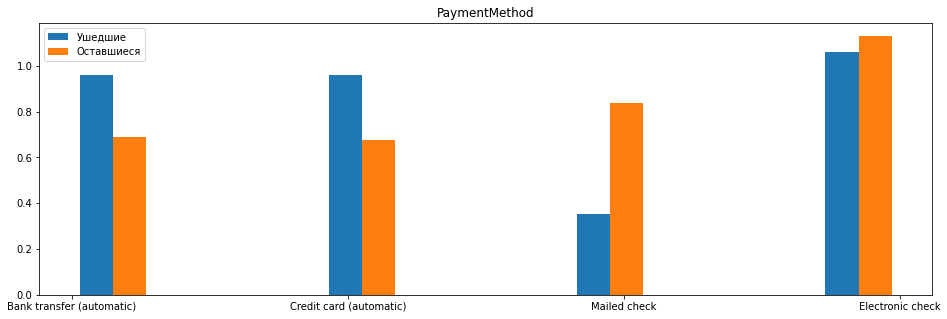

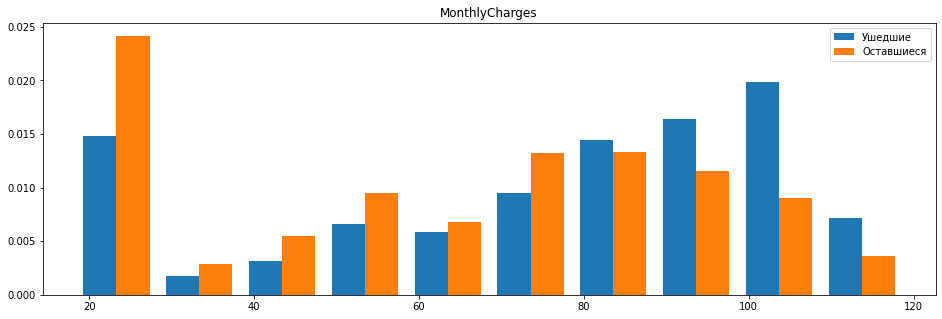

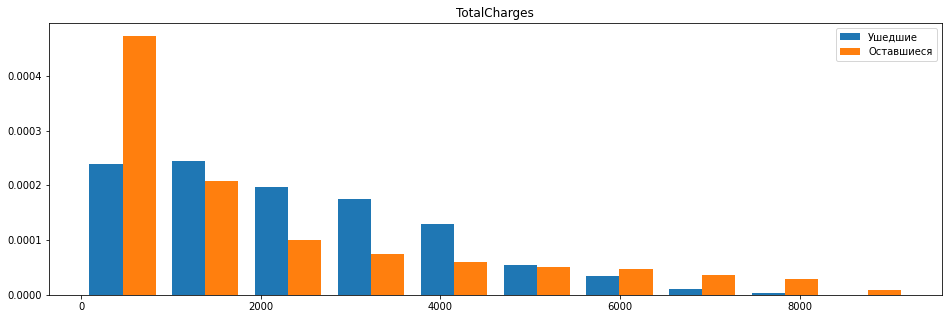

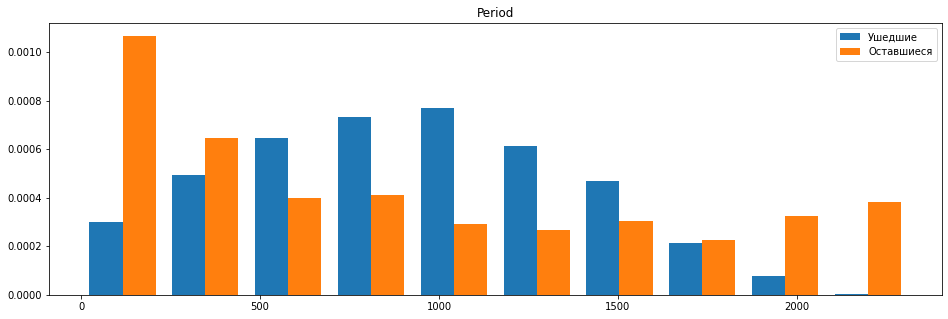

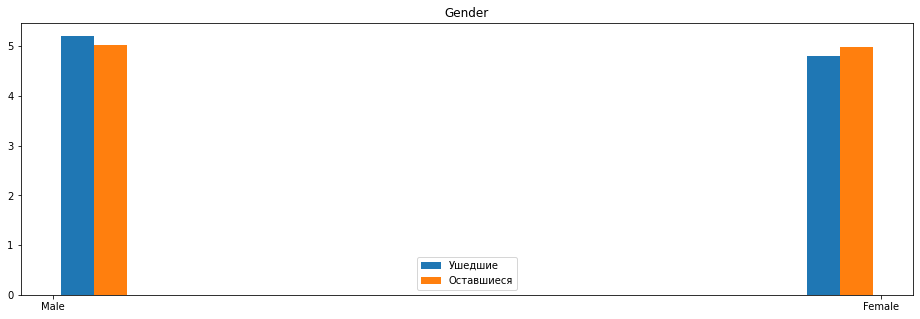

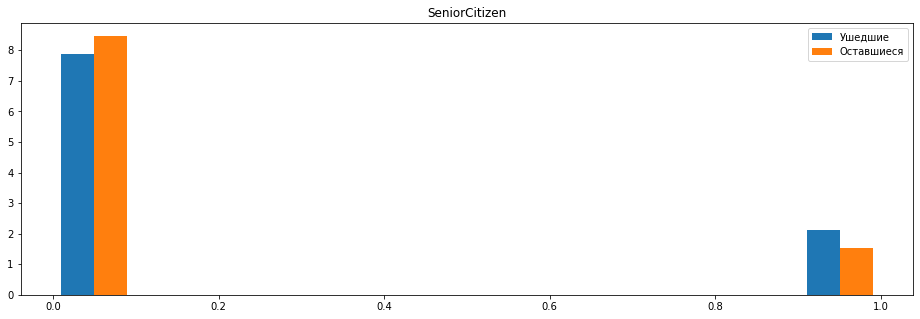

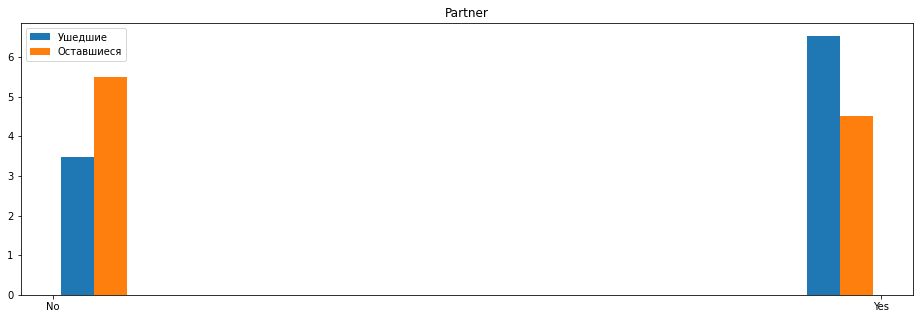

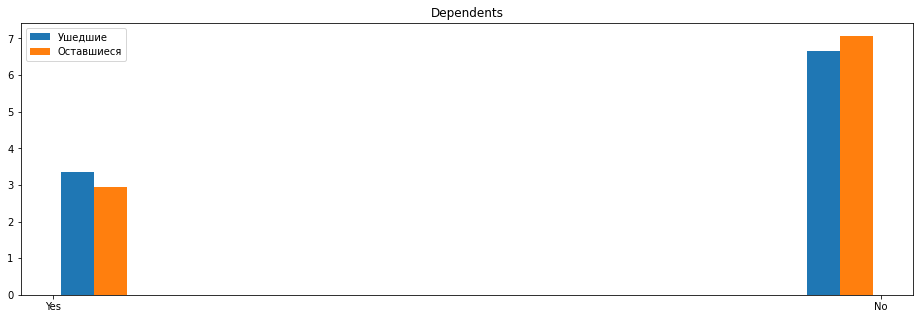

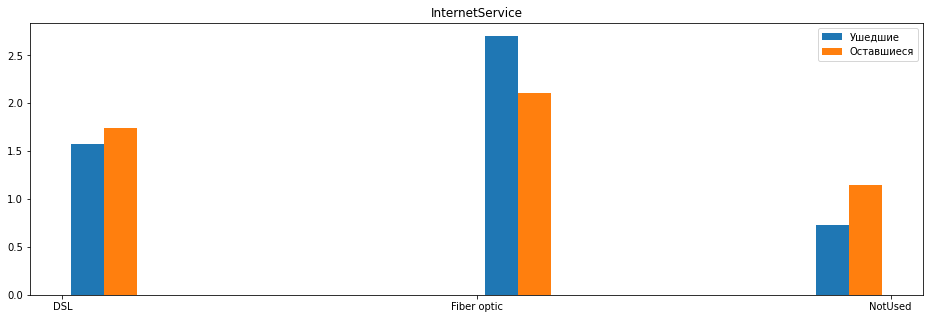

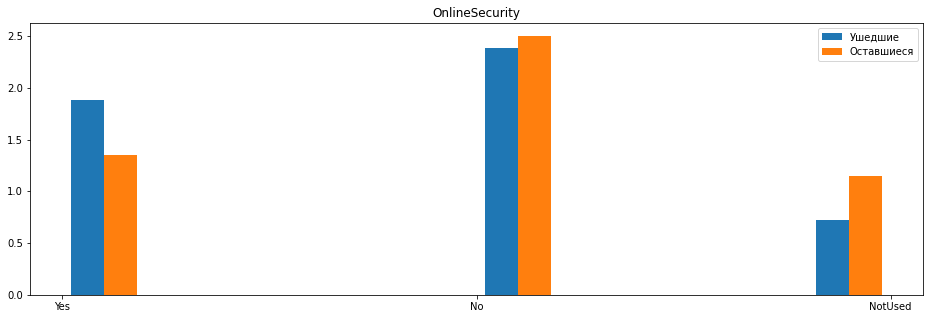

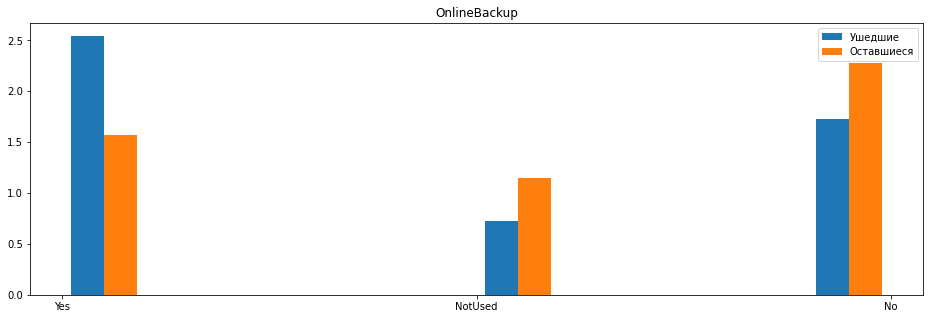

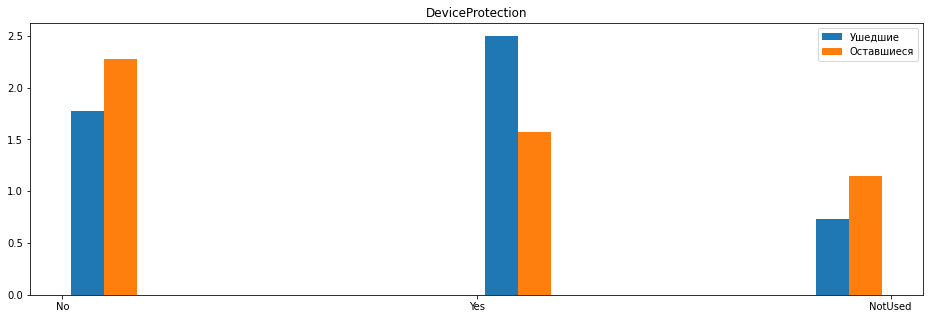

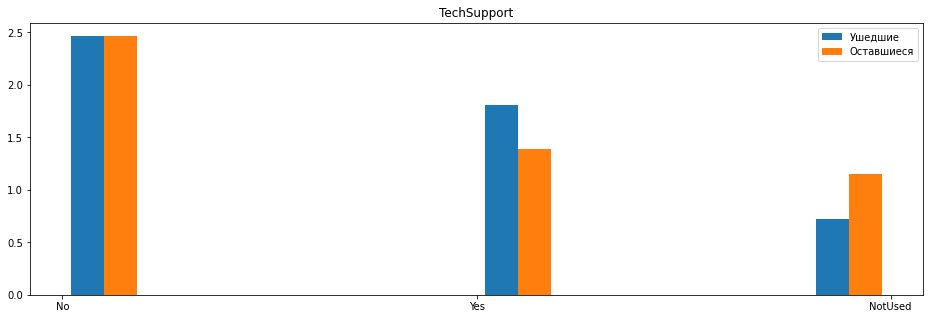

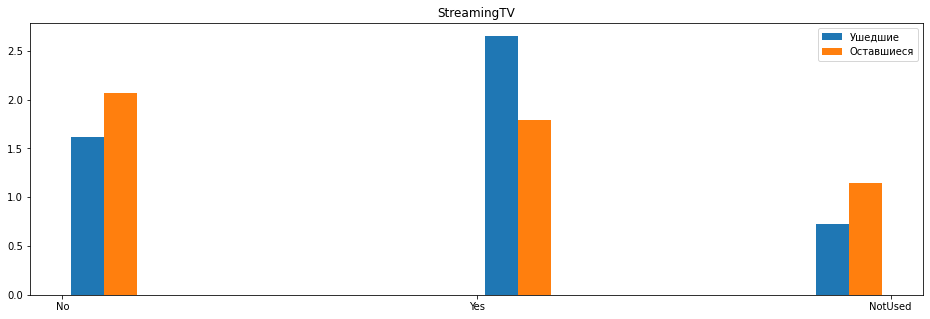

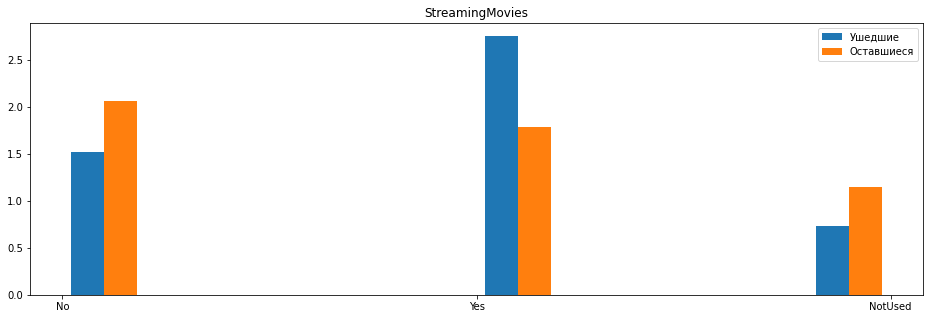

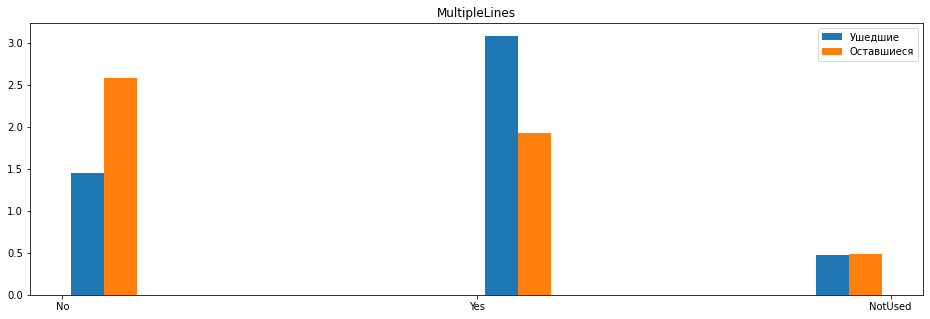

In [34]:
for x in column:
    hist(x)

на графиках можно увидеть:

- тип оплаты показывает - чаще всего оставшиеся клиенты находятся на месячной подписке, в то время как в подписке на год/два отток клиентов выше. но пока из этого сложно сделать вывод 
- среди способов оплаты выделяются банкоский перевод и оплата кредитной карты - среди этих оплат больше оттока 
- клиенты, ежемесячные траты которыз меньше 30 склонны оставаться, а при росте стоимости оплаты в месяц число ушедших увеличивается 
- новые клиенты чаще остаются, однако после года обслуживания кол-во ушедших превышает кол-во оставшихся. отток снова спадает только среди тех клиентов, которые на сервисе более 1750 дней
- клиенты, подключившие себе доп услуги, склонны уходить (это как раз может влиять на пункт с ежемесячными тратами) 


попробуем использовать другой метод визуализации

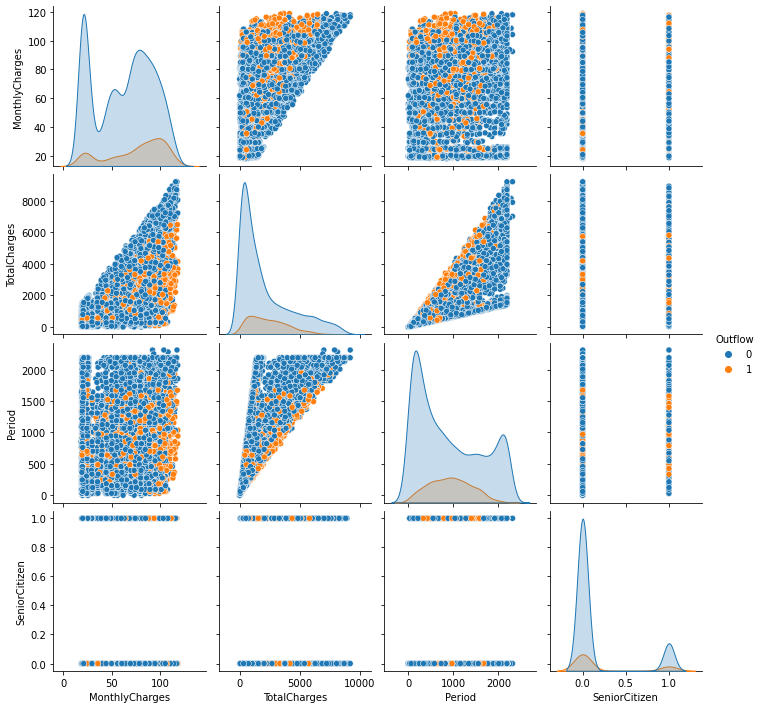

In [35]:
sns.pairplot(Outflow_df,hue ='Outflow', height = 2.5, kind = 'scatter')

- мы опять можем заметить, что чем больше разовый ежемесячный платеж клиента (больше подключено доп услуг) тем вероятнее клиент откажется от нашего оператора

### детальное изучение признаков

оставим только интересующие нас столбцы и пройдемся по каждому из признаков, по которым возникают вопросы, а именно: 
- MonthlyCharges
- Type
- PaymentMethod


In [36]:
intresting_column = ['Type',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'PaperlessBilling',                    
 'Period',
 'Partner',
 'SeniorCitizen',                    
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

#### MonthlyCharges

 разделим выборку на тех, кто платит в среднем меньше 40 в месяц, и на тех кто платит больше 90

In [37]:
mc_low = Outflow_df.query('MonthlyCharges < 40')


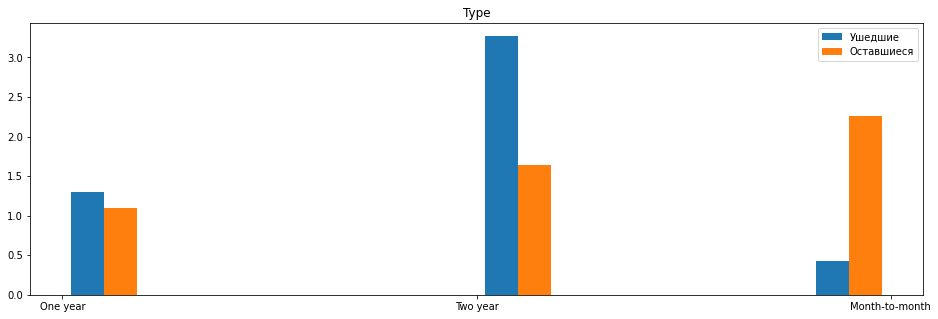

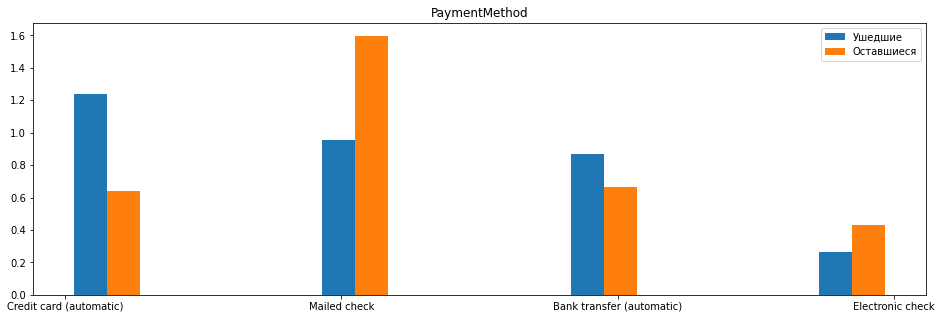

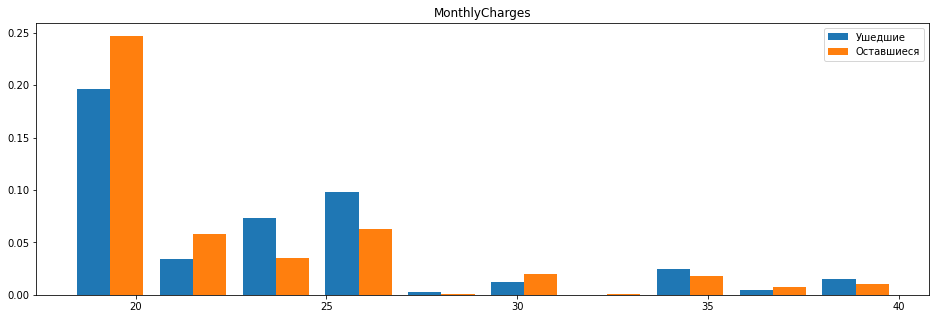

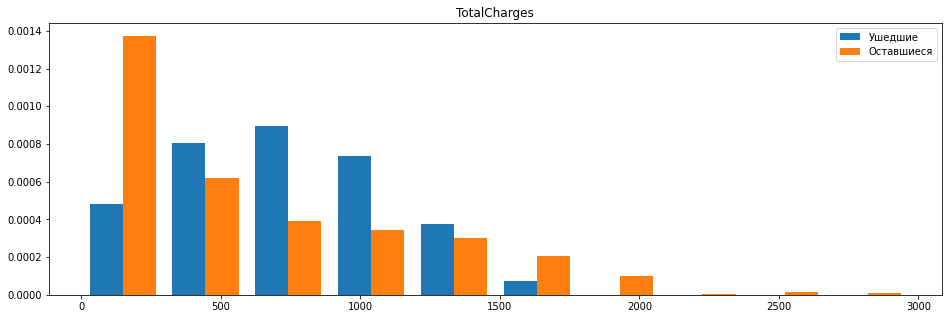

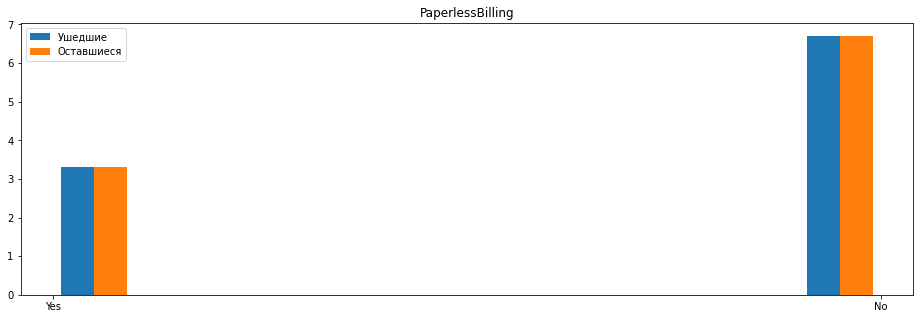

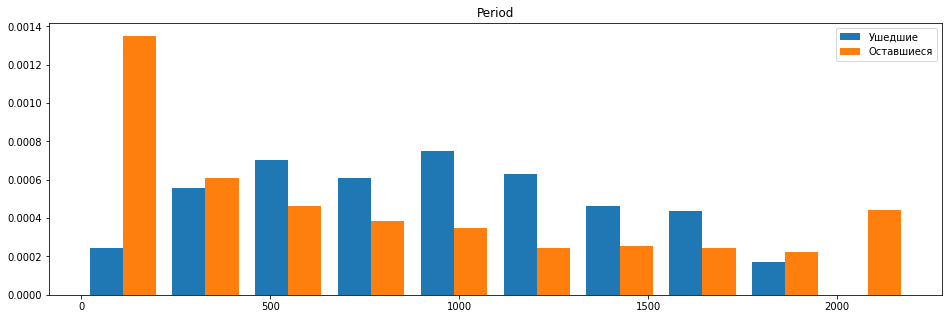

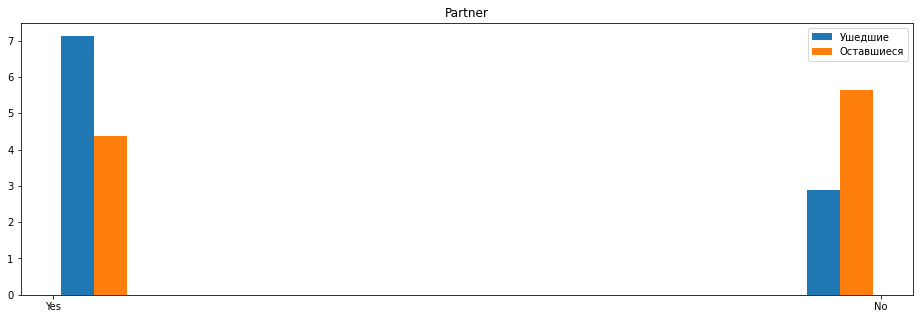

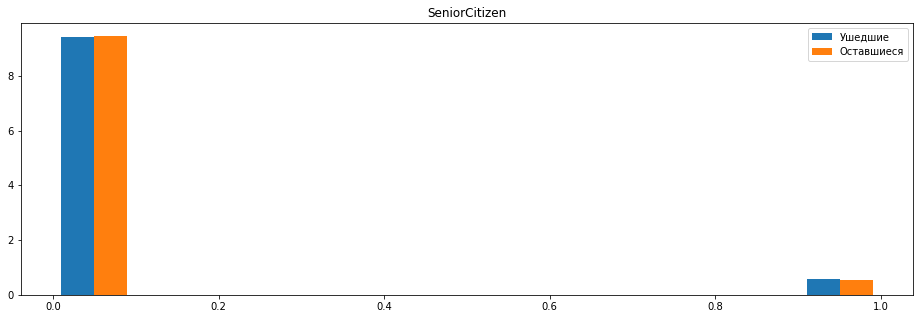

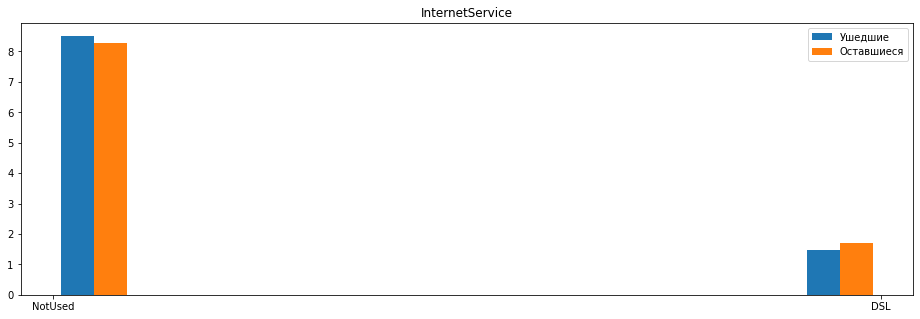

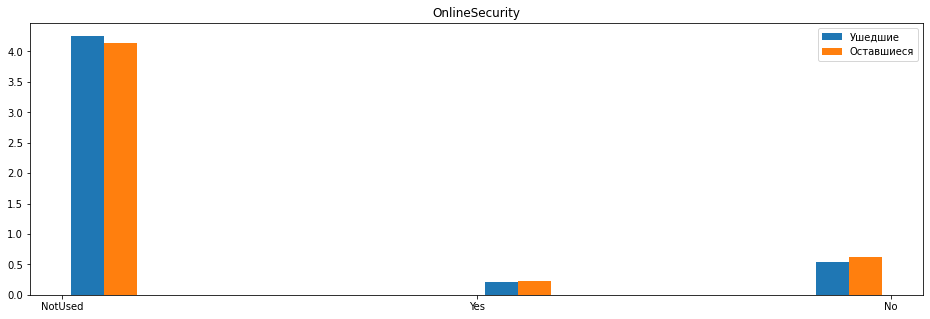

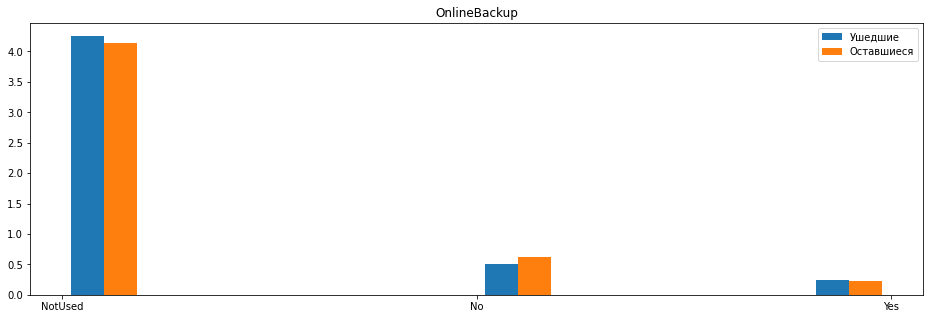

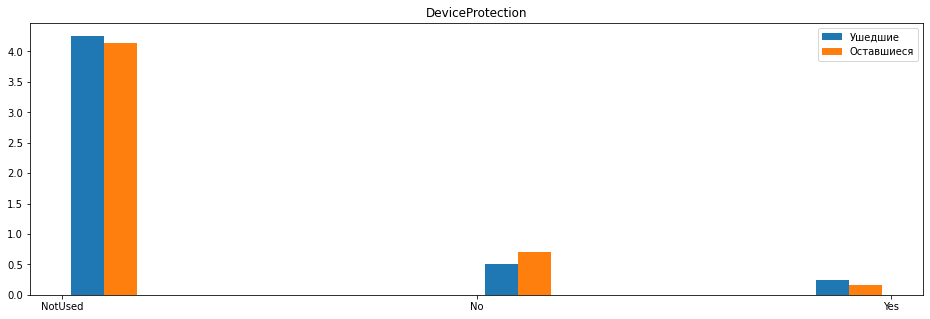

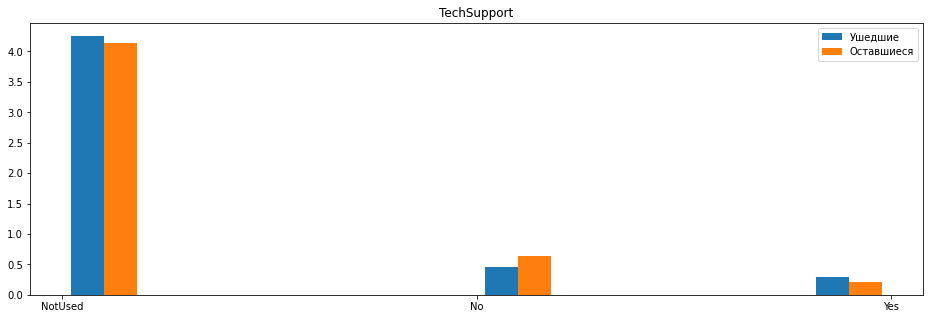

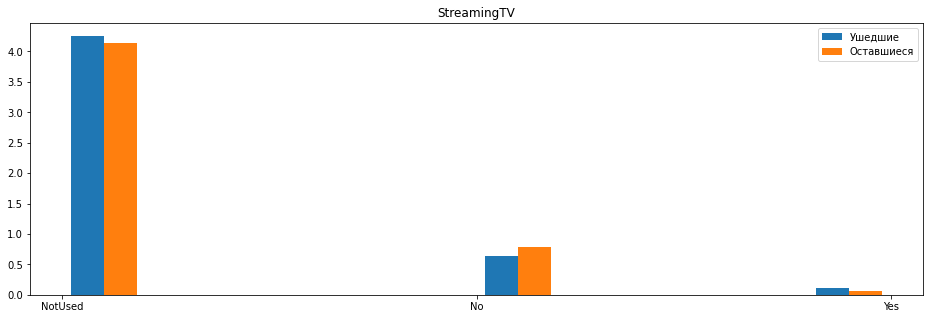

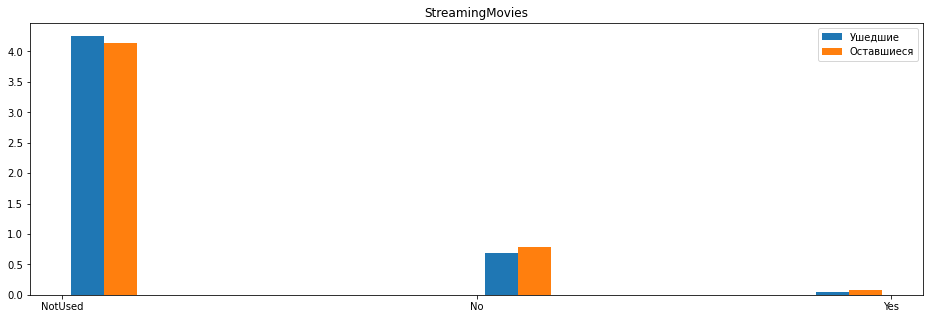

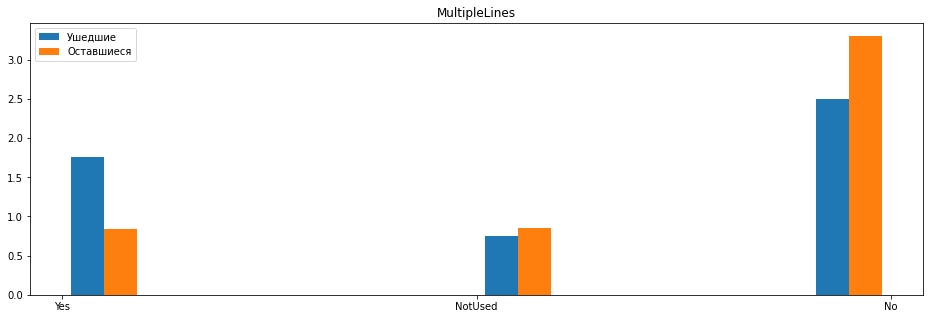

In [38]:
def hist_low(column):
    plt.hist([mc_low[mc_low.Outflow == 1][column], mc_low[mc_low.Outflow == 0][column]], label=['Ушедшие', 'Оставшиеся'], density=True);
    plt.legend();
    plt.title(column);
    plt.show();
    
for x in intresting_column:
    hist_low(x)    

In [39]:
mc_higн= Outflow_df.query('MonthlyCharges > 90')

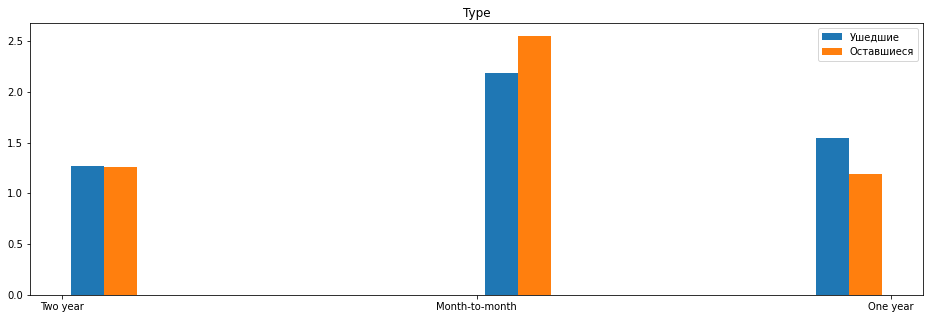

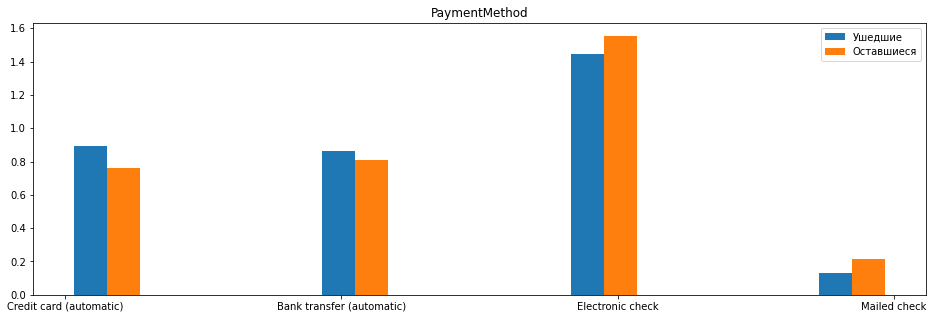

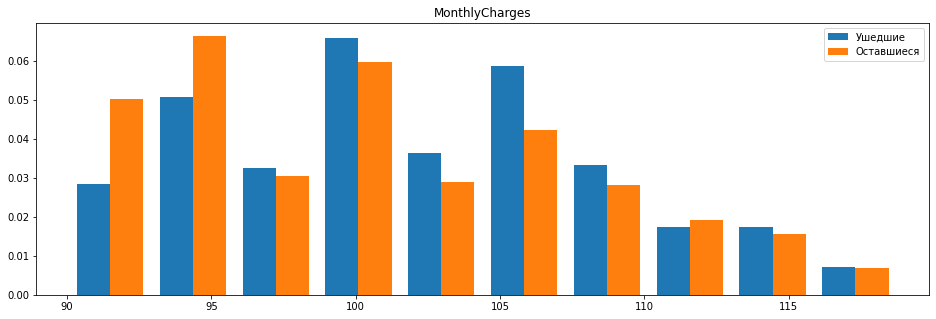

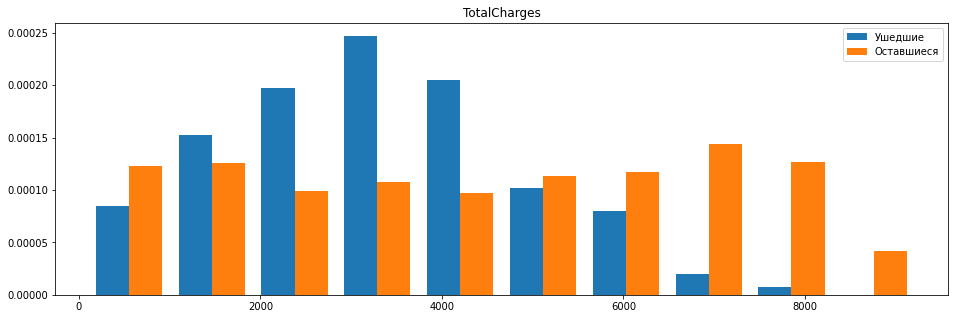

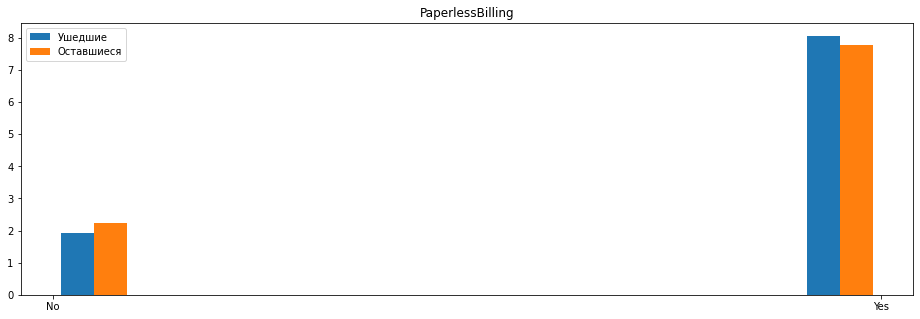

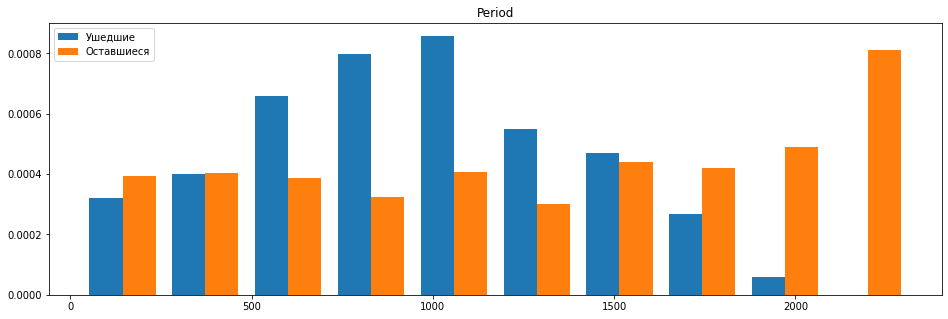

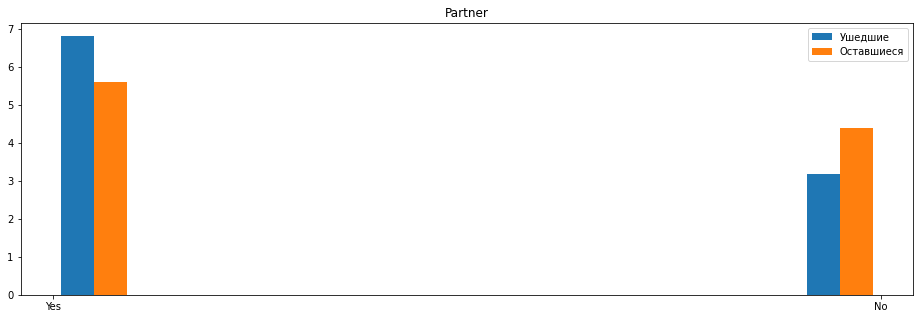

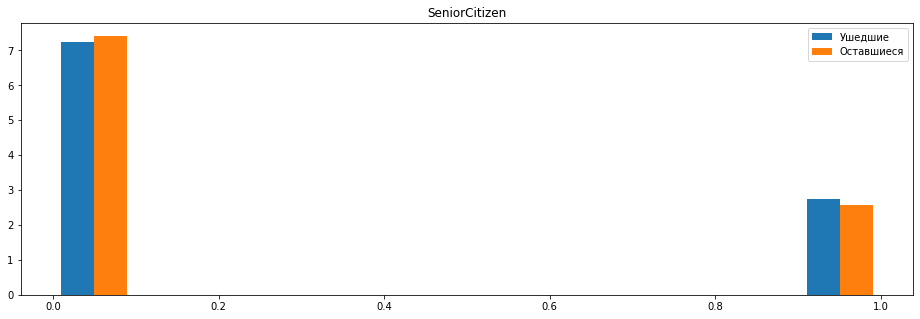

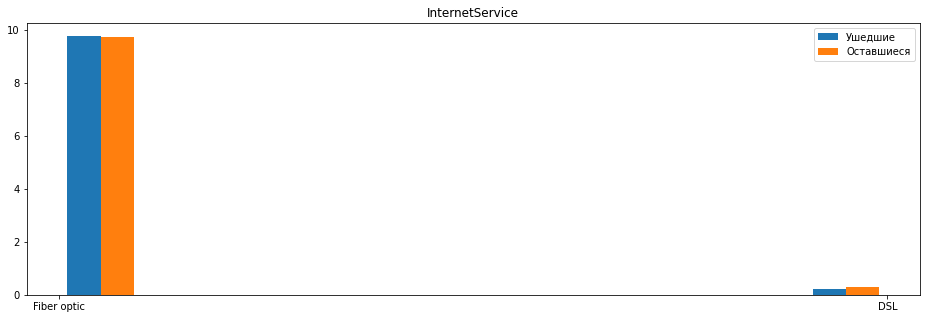

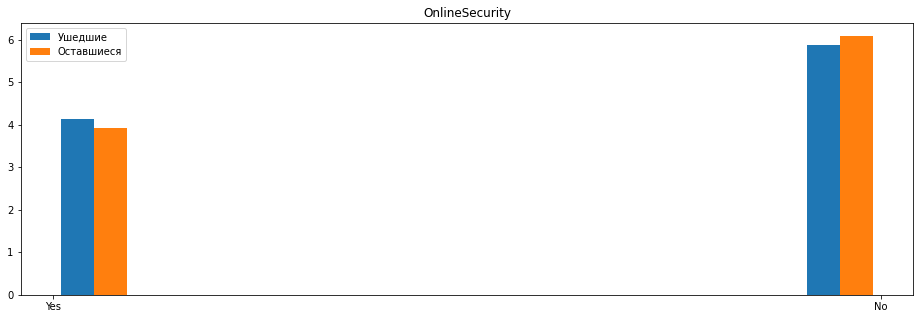

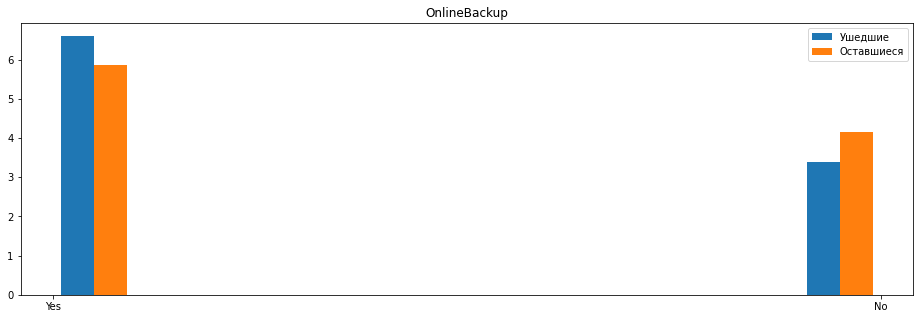

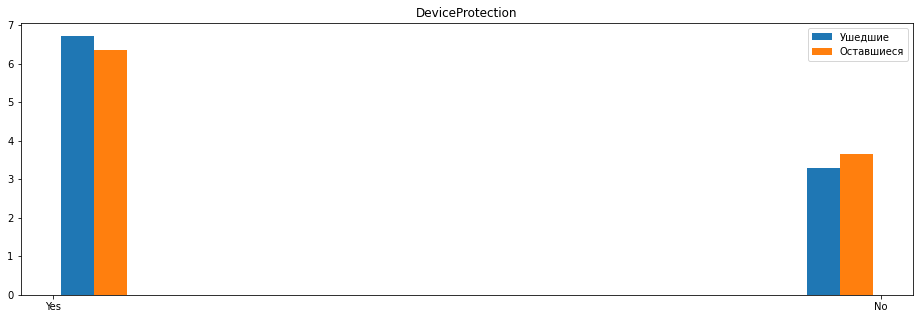

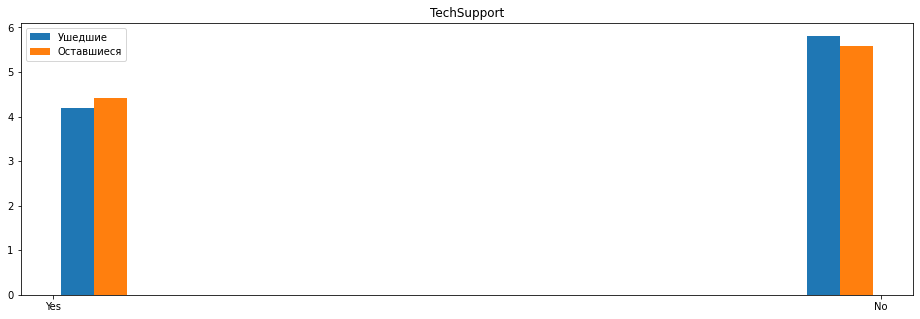

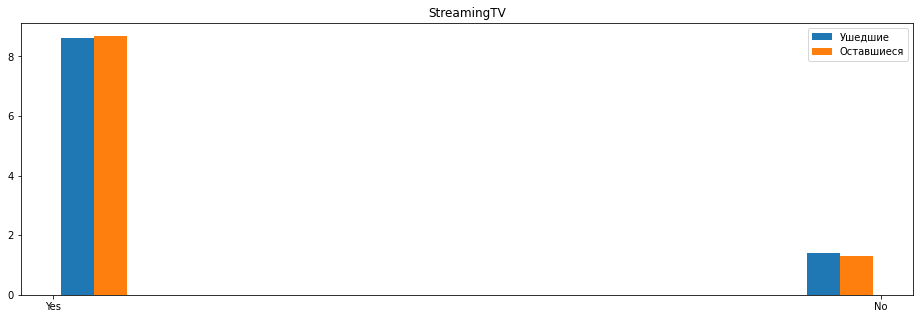

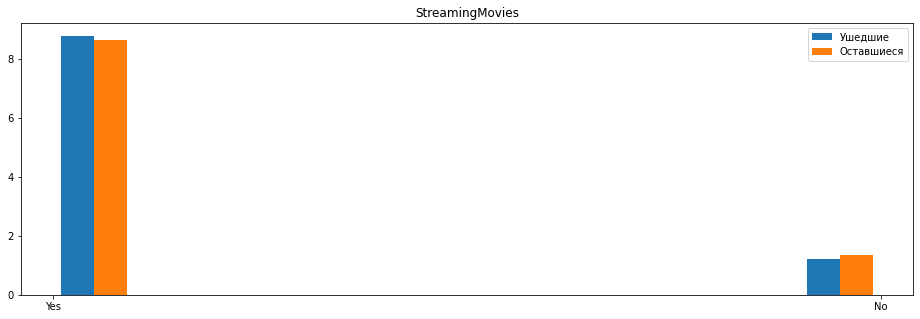

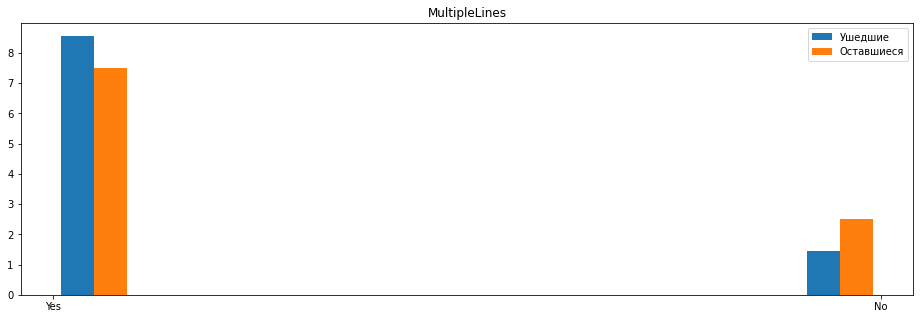

In [40]:
def hist_low(column):
    plt.hist([mc_higн[mc_higн.Outflow == 1][column], mc_higн[mc_higн.Outflow == 0][column]], label=['Ушедшие', 'Оставшиеся'], density=True);
    plt.legend();
    plt.title(column);
    plt.show();
    
for x in intresting_column:
    hist_low(x)    

разбив выборки на клиентов с низкой ежемесячной оплатой и высокой оплатой, можно увидеть:

- если у клиента ежемесячная оплата ниже 40 и он платит помесячно, то вероятность его ухода мала, однако если он платит сразу за два года, то вероятность его уходя резко возрастает 
- так же заметно влияние партнера. у тех клиентов, кто платит в месяц меньше 40, наличие партнера значительно увеличивает шанс ухода. сложно сказать с чем это связано



уберем из выборки старых пользователей, среди которых вероятность оттока минимальная, и еще раз посмотрим на коиентов с высокой месячной оплатой

In [41]:
mc_higн_per = mc_higн.query('Period < 1500')

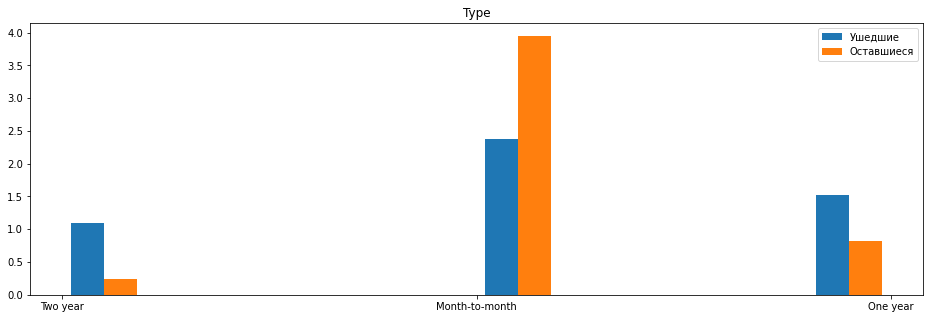

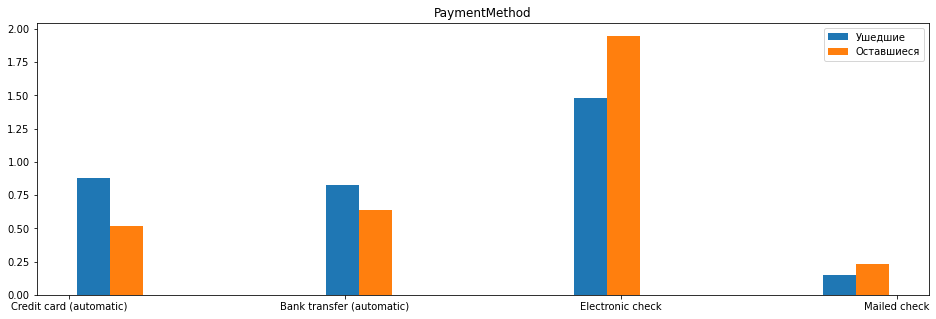

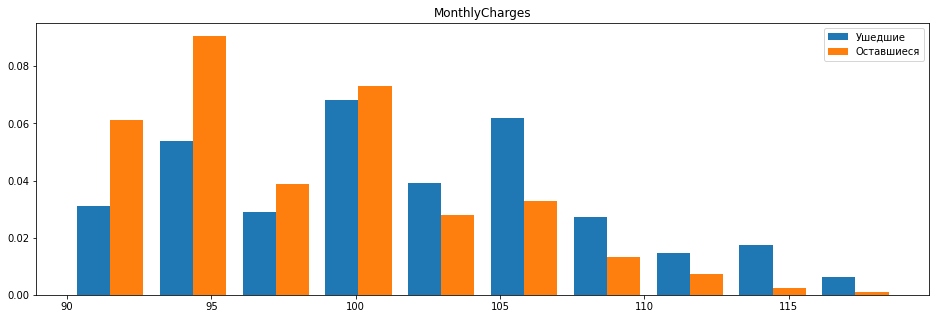

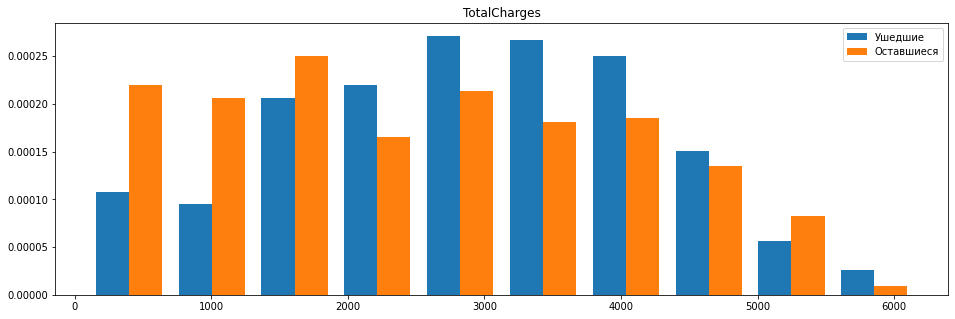

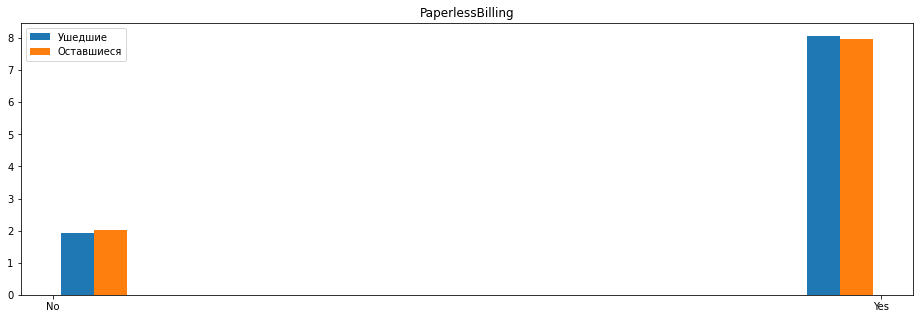

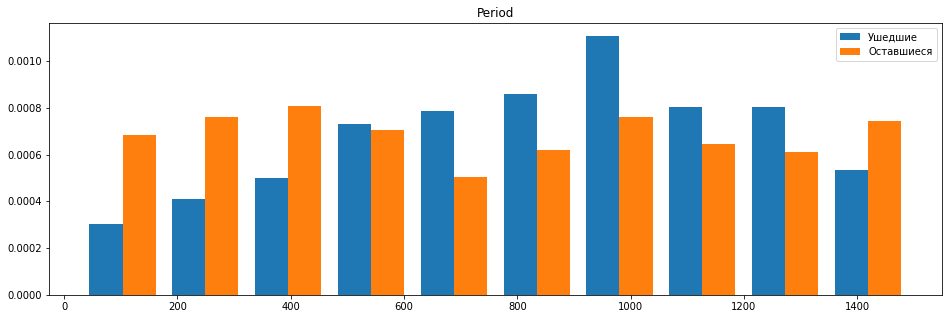

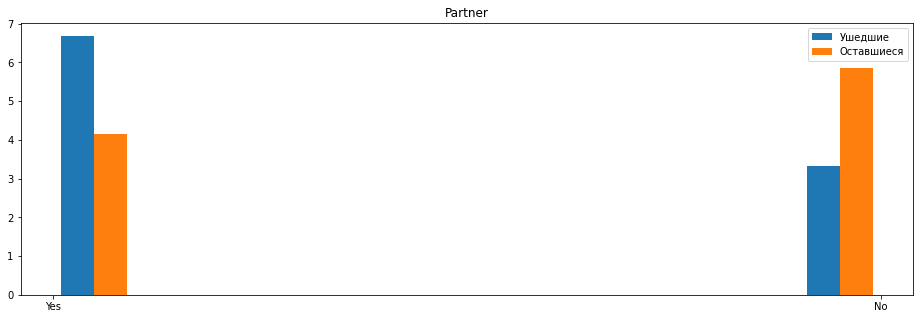

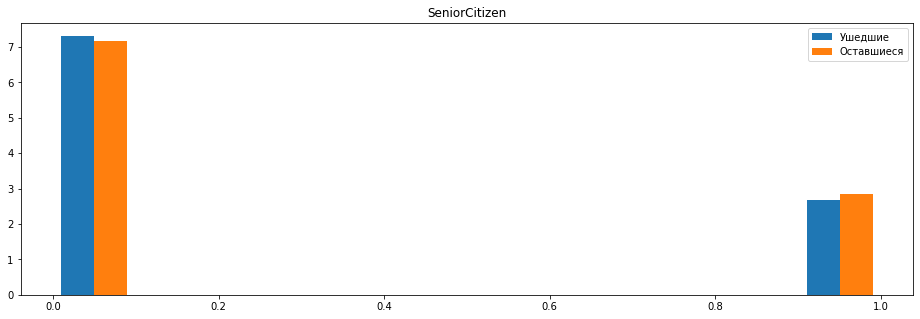

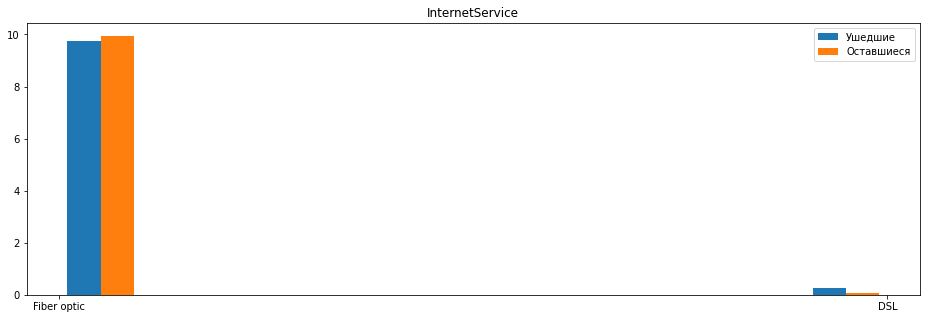

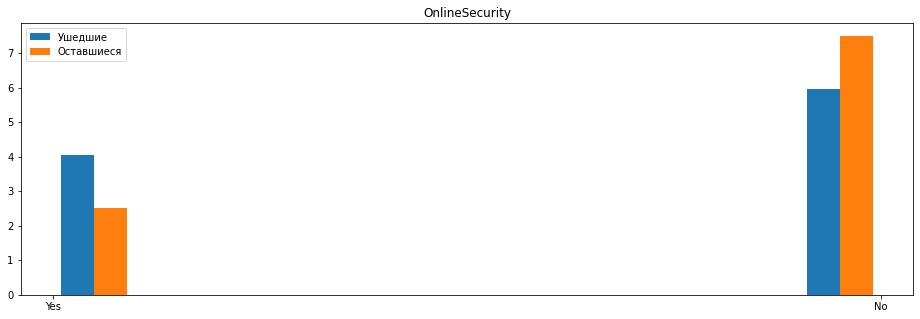

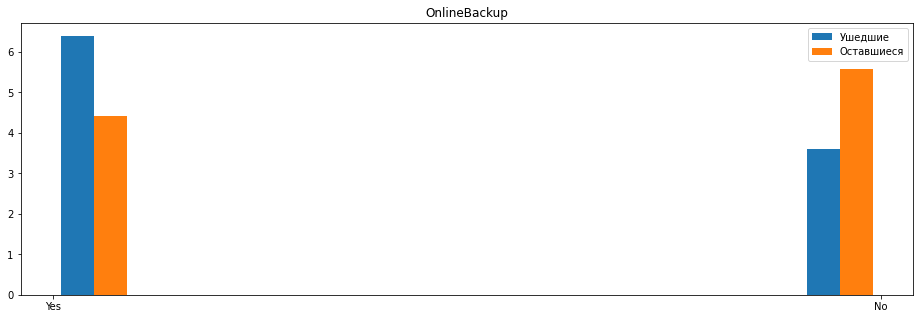

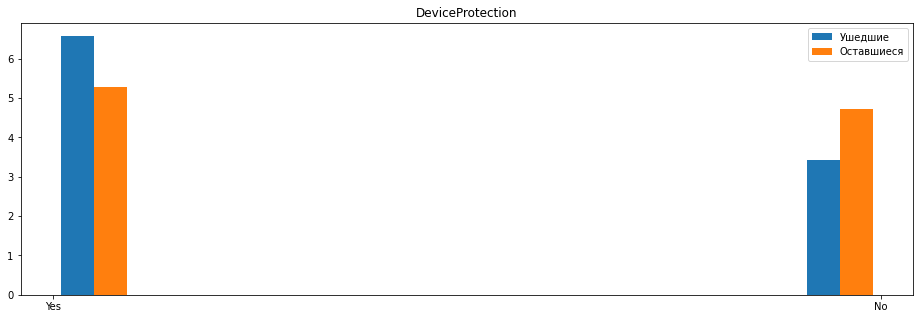

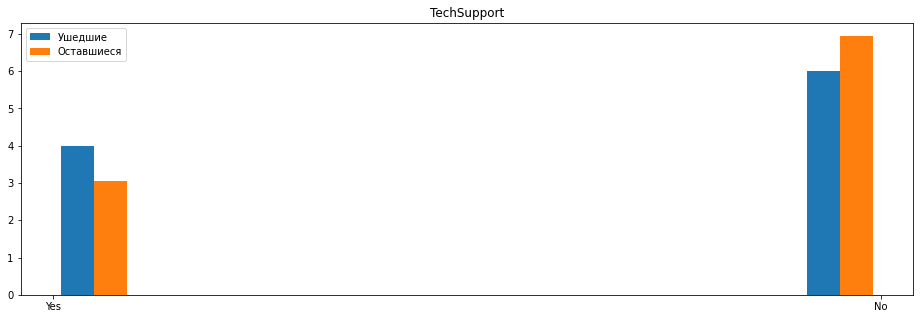

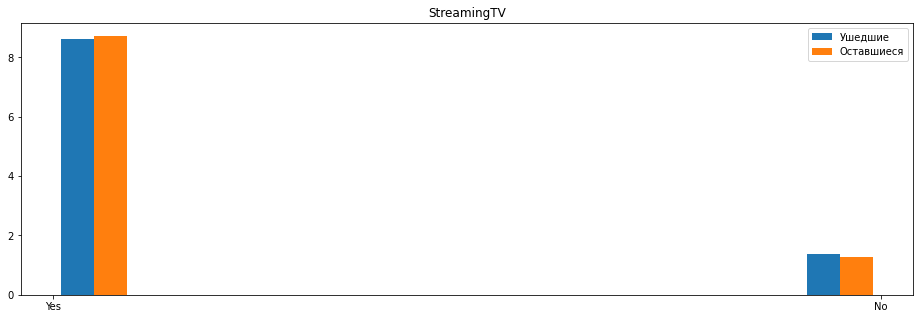

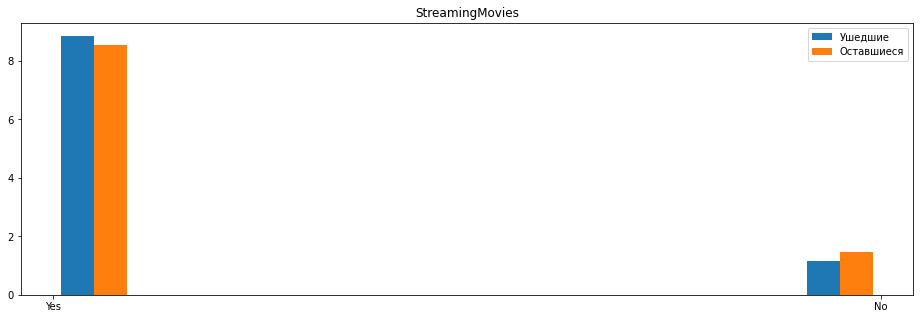

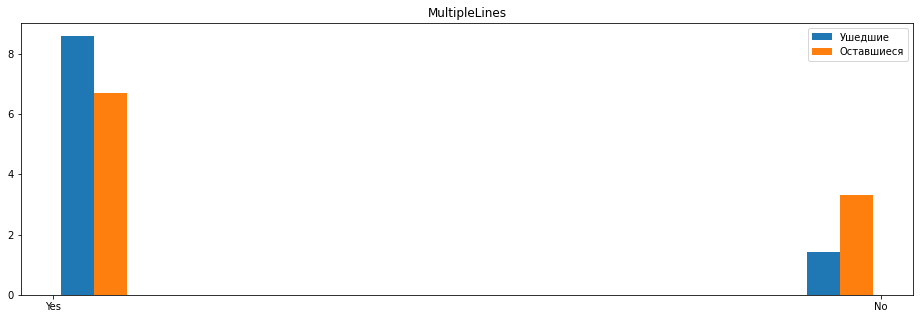

In [42]:
def hist_low(column):
    plt.hist([mc_higн_per[mc_higн_per.Outflow == 1][column], mc_higн_per[mc_higн_per.Outflow == 0][column]], label=['Ушедшие', 'Оставшиеся'], density=True);
    plt.legend();
    plt.title(column);
    plt.show();
    
for x in intresting_column:
    hist_low(x)

так становится лучше видна проблема оплаты - основная часть остающихся с оператором - платят помесячно, в то время как основная часть тех, кто уходит - платят сразу за год или за два 

#### PaymentMethod

посмотрим на метод оплаты - Mailed check т.к. в общей выборке, там меньше всего оттока 

In [43]:
paymentmethod = Outflow_df.query('PaymentMethod == "Mailed check"')

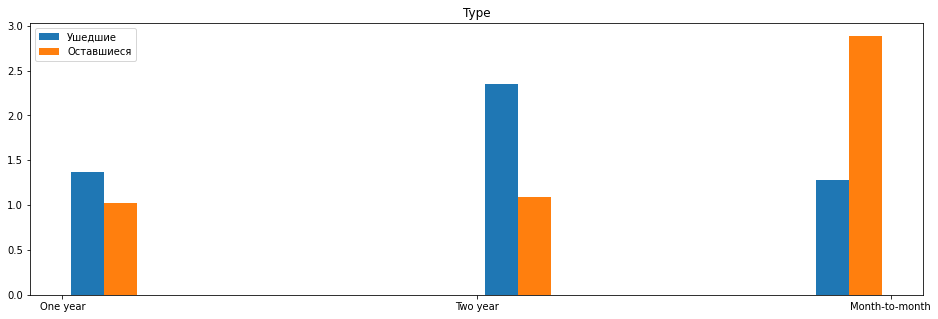

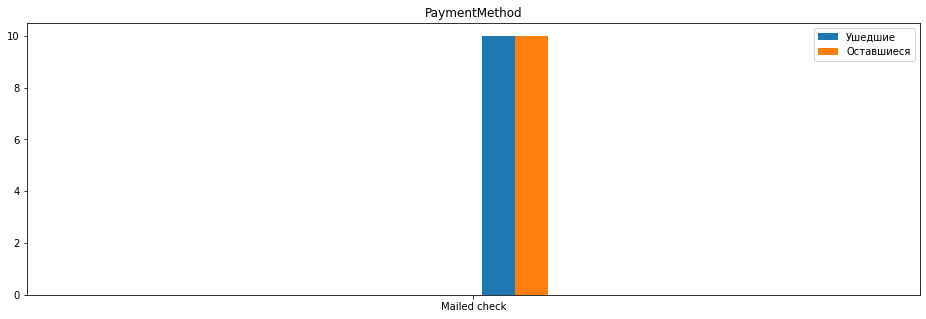

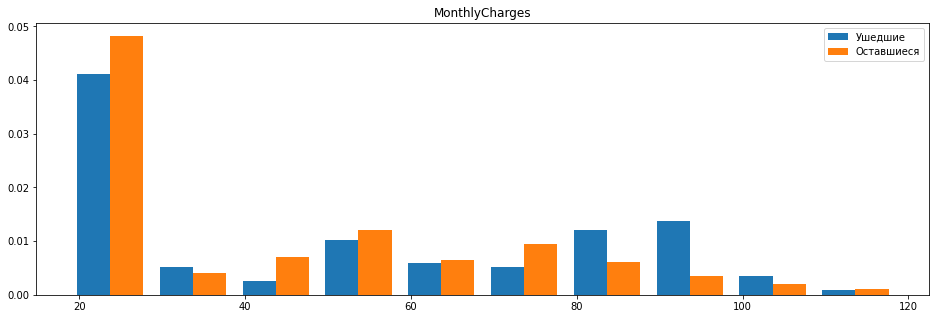

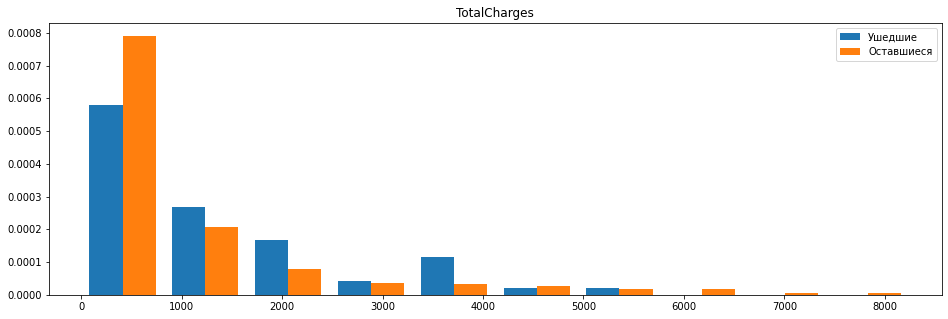

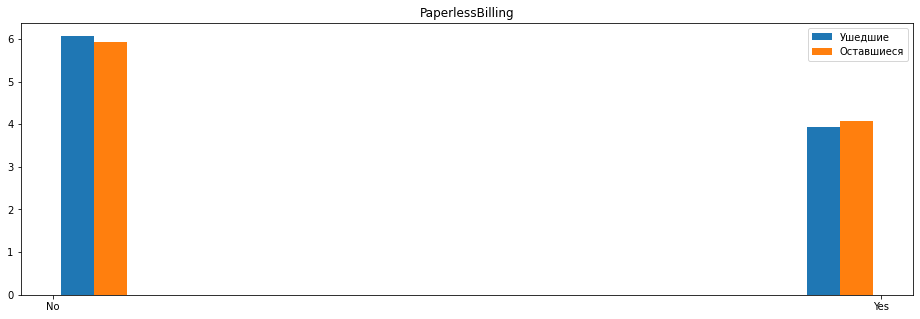

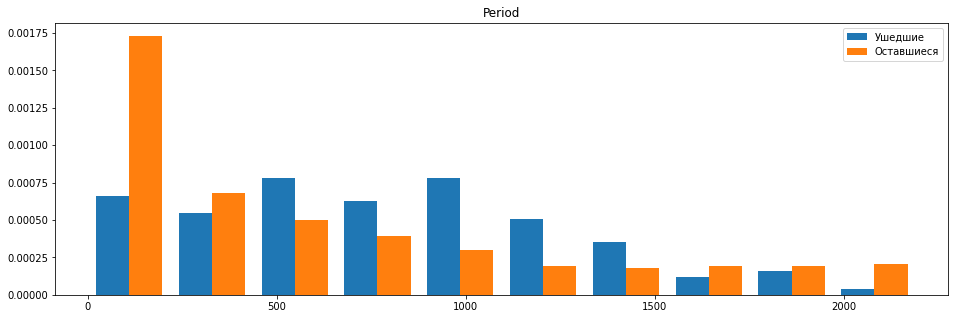

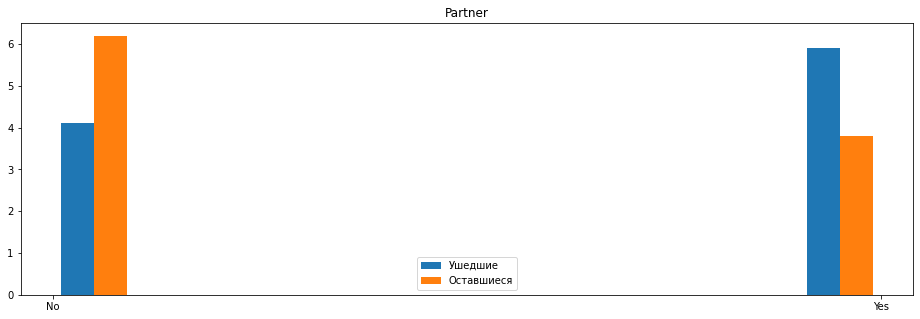

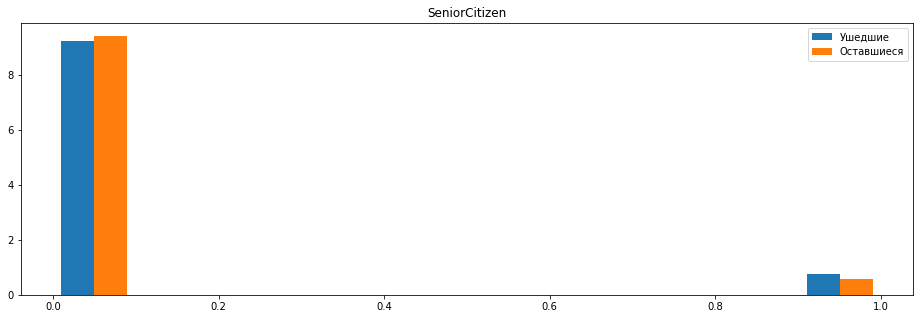

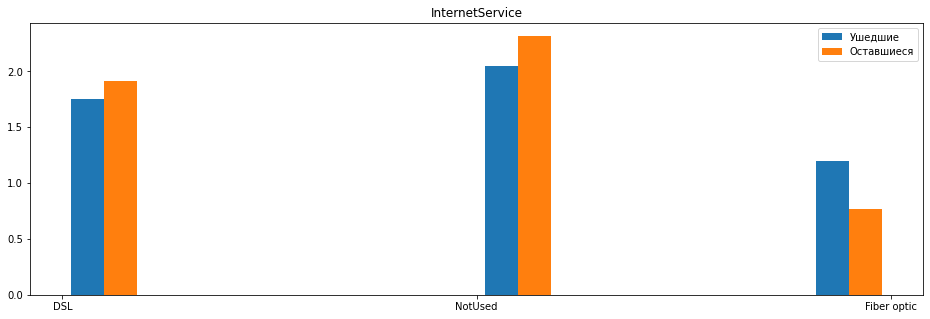

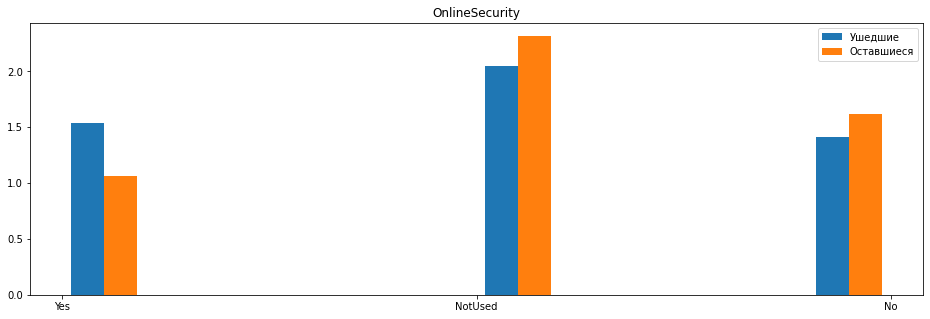

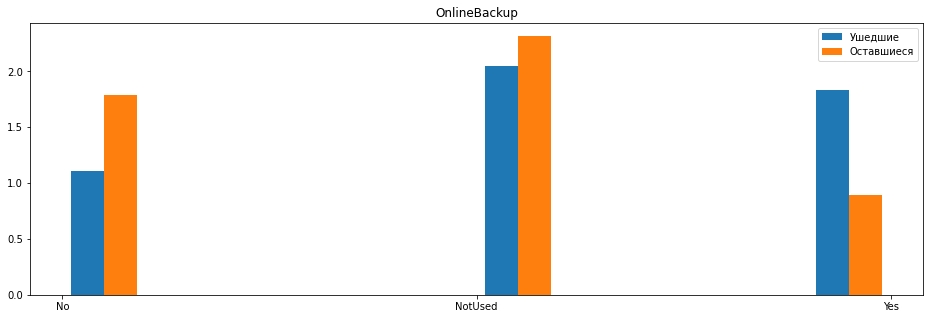

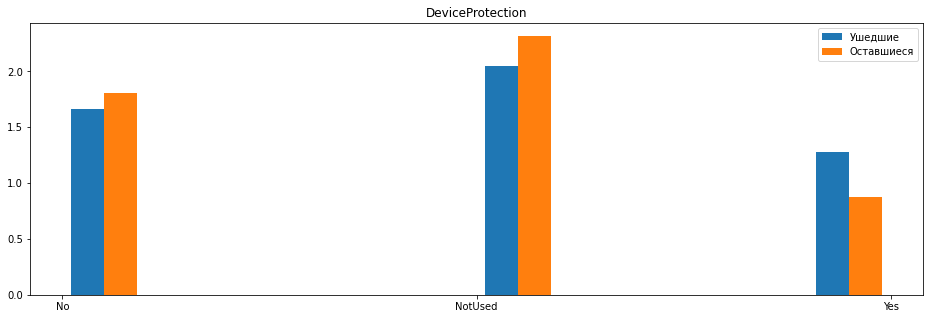

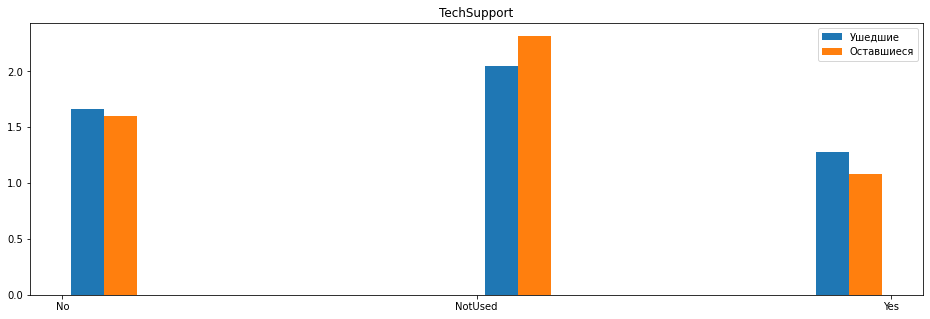

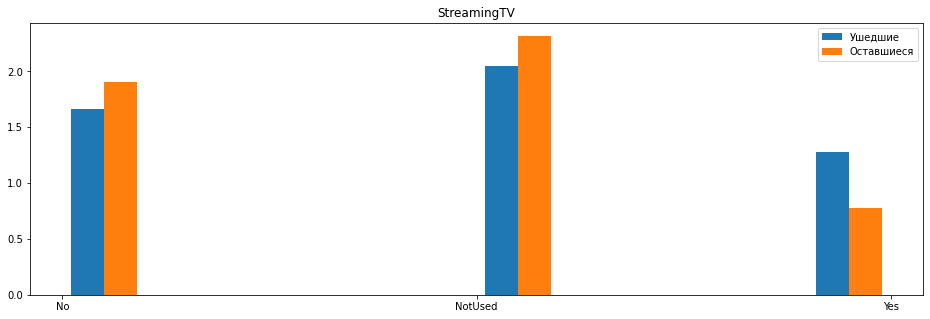

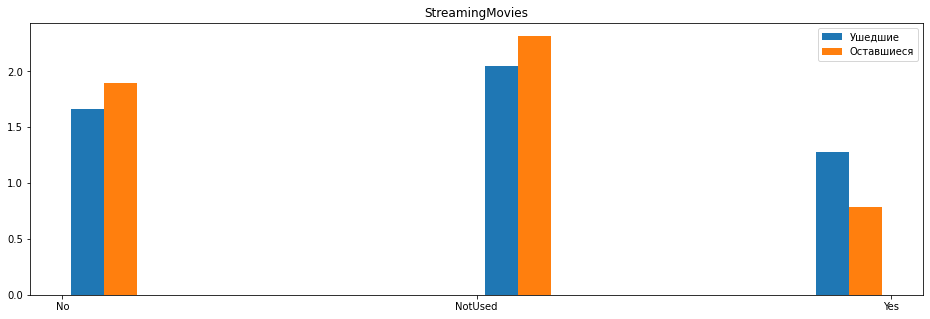

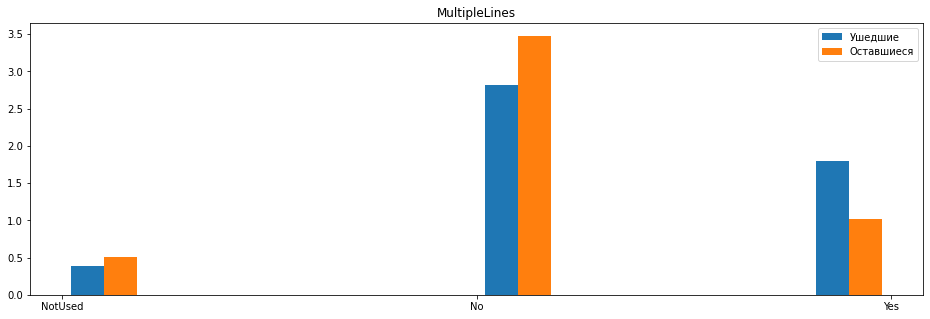

In [44]:
def hist_low(column):
    plt.hist([paymentmethod[paymentmethod.Outflow == 1][column], paymentmethod[paymentmethod.Outflow == 0][column]], label=['Ушедшие', 'Оставшиеся'], density=True);
    plt.legend();
    plt.title(column);
    plt.show();
    
for x in intresting_column:
    hist_low(x)  

- можно заметить, что способ оплаты не так влияет на уход клиента. Mailed check имеет меньший отток, потому что им пользуються чаще всего новые клиенты (а их отток меньше) и те, кто не подлкючают доп услуг 
- однако даже в этой выборке видно большое кол-во ушедших клиентов, выбирающих тип оплаты на два года. это еще раз подчеркивает что с типом оплаты что-то не так

#### Type

посмотрим на выборку тех, кто ставит оплату сразу за два года, и уберем из неё "старичков", которые остаются с оператором независимо от условий 

In [45]:
type_df = Outflow_df.query('Type == "Two year"')

In [46]:
type_df = type_df.query('Period < 1500')

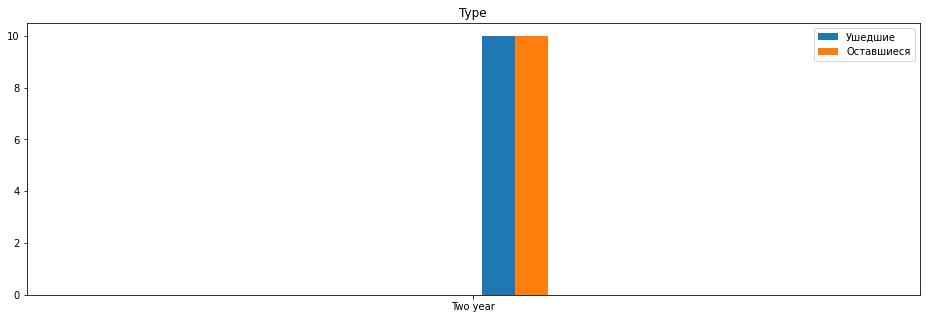

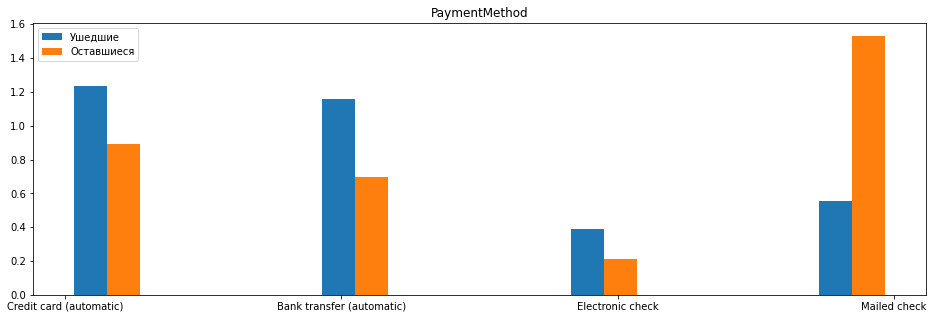

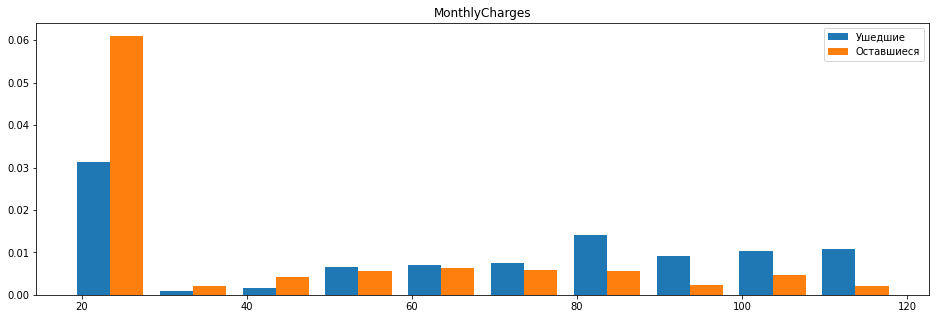

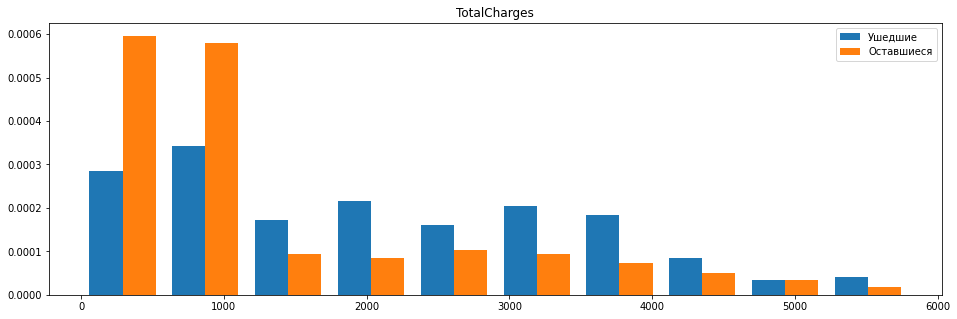

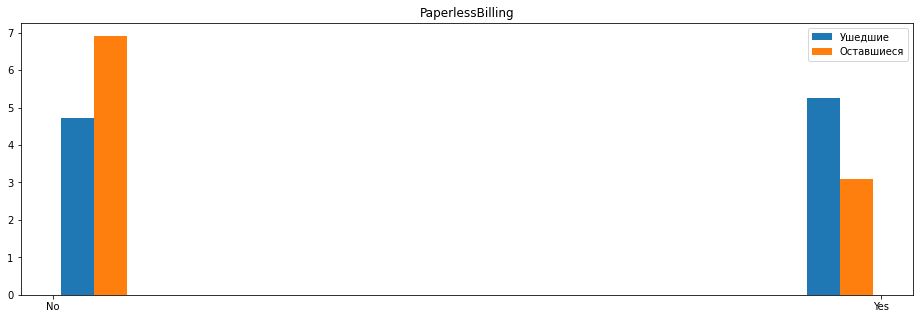

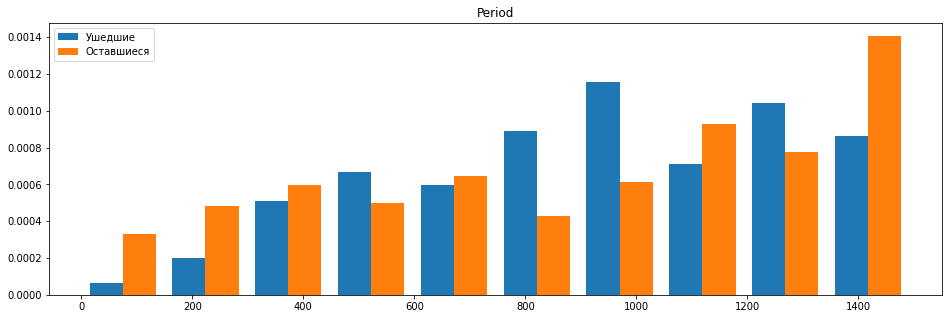

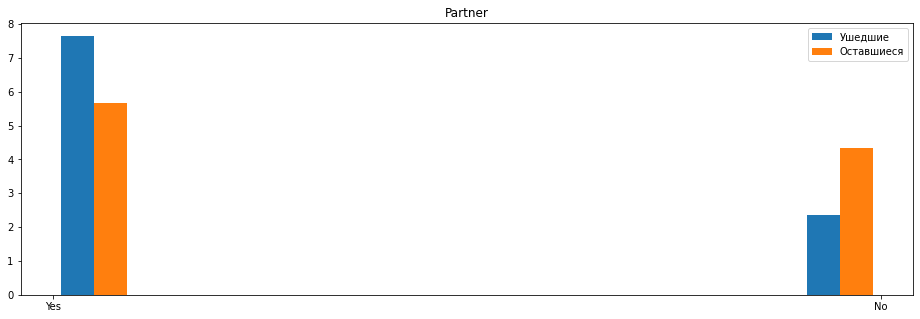

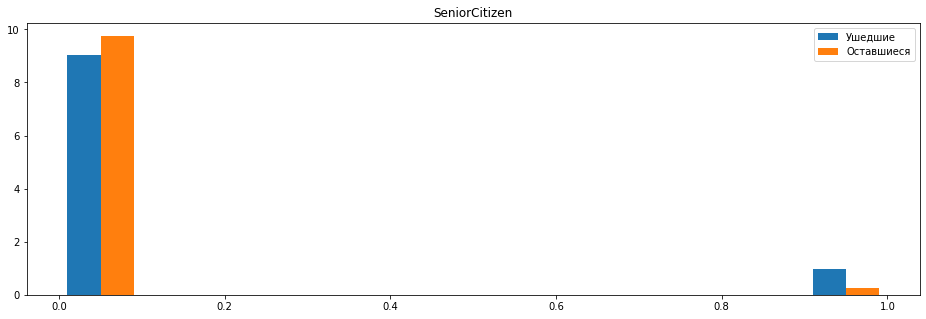

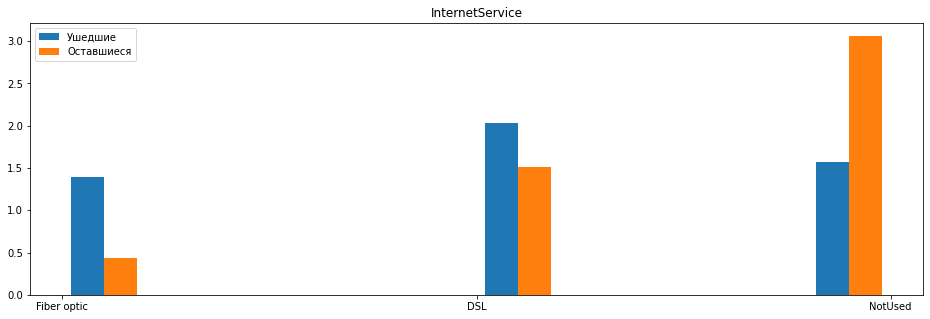

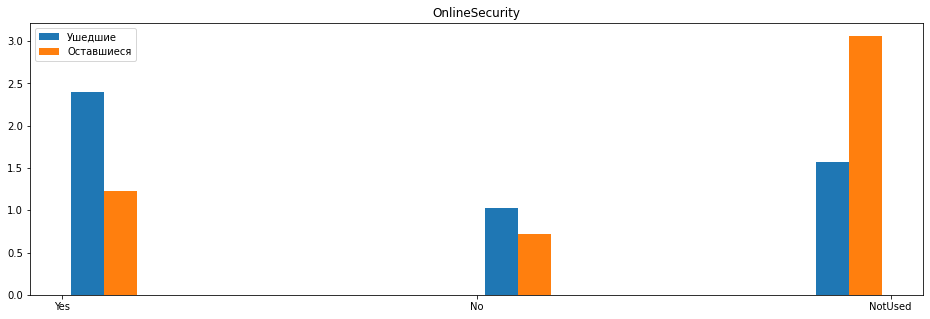

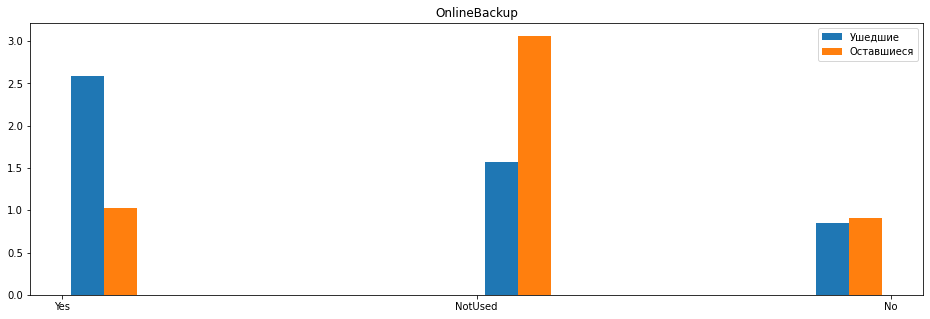

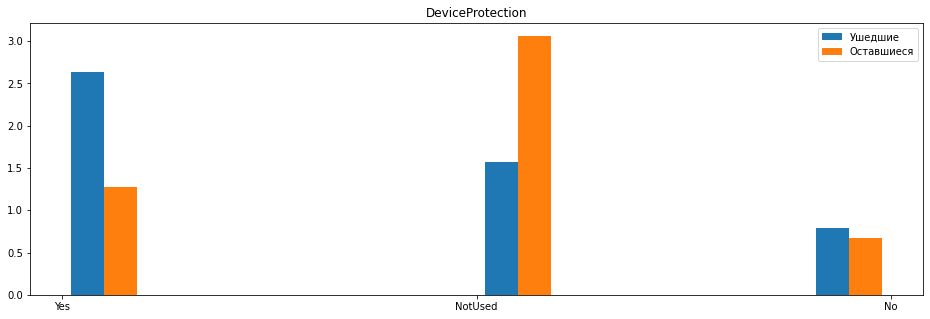

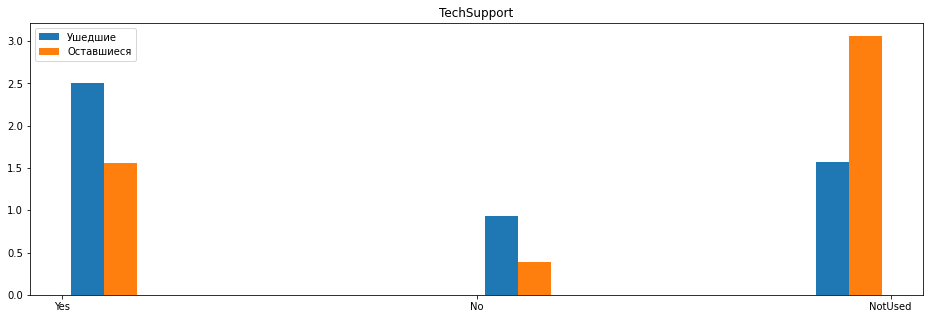

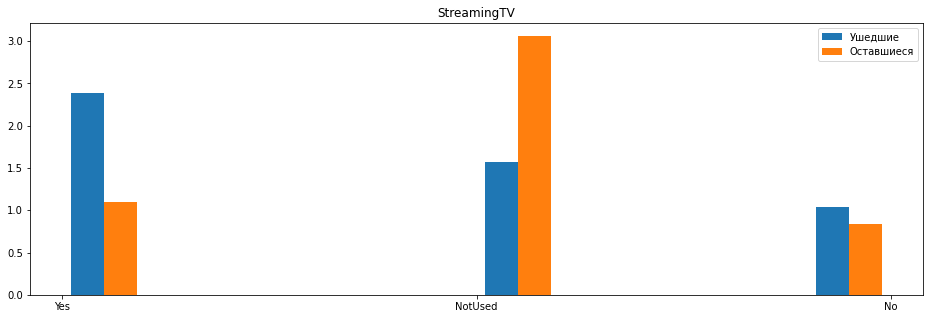

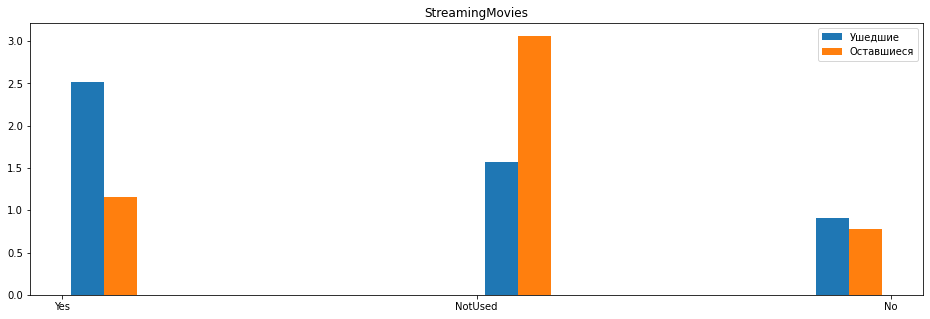

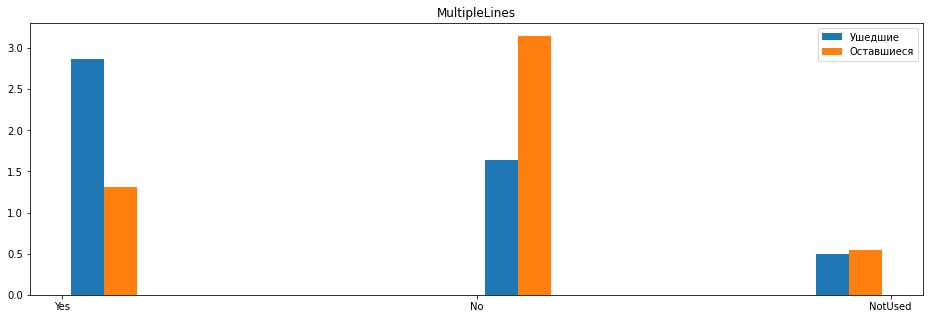

In [47]:
def hist_low(column):
    plt.hist([type_df[type_df.Outflow == 1][column], type_df[type_df.Outflow == 0][column]], label=['Ушедшие', 'Оставшиеся'], density=True);
    plt.legend();
    plt.title(column);
    plt.show();
    
for x in intresting_column:
    hist_low(x)  

стало лучше видно, что клиенты, подключившие доп услуги и,соответсвенно, чей ежемесячный средний платеж больше - склонны уходить от оператора. соответсвенно те, кто не подключают доп услуги, по большей части остаются 

выводы: 
1. самая заметная проблема находится в типе оплаты, а именно за год и за два года сразу - независимо от других критериев, эти типы оплаты больше всего влияют на отток клиентов 
2. клиенты, чей средний чек за месяц больше - тоже склонны уходить.
3. пик оттока клиентов наступает после полутора лет пользования услугами оператора
4. стоит обратить внимание на метод оплаты: кредитная карта и автоматический трансфер банка имеют повышенный отток клиентов. однако сложно найти первопричину, т.к. те - кто платят за год или за два года сразу - пользуються в основном этими методами оплаты и как раз берут доп услуги 

5. так же стоит обратить внимание на коррелирующие между собой признаки, а именно такие пары как: `StreamingTV` и `StreamingMovies`, `OnlineBackup` и `DeviceProtection`. эти пары ведут себя схожим образом, на следующем этапе стоит обратить на них особое внимание 




по медианым значениям можно увидеть разницу в поведении ушедших и оставшихся пользователей 

## предмодельная подготовка

### корреляционный анализ признаков

преобразуем столбец `SeniorCitizen` в `object`

In [48]:
Outflow_df['SeniorCitizen'] = Outflow_df['SeniorCitizen'].astype('str')

In [50]:
Outflow_df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

перед тем как смотреть на корреляцию признаков, удалим ненужные,даты начала и конца пользования оператором

In [51]:
Outflow_df_drop = Outflow_df.drop(['BeginDate','EndDate'], axis=1)

определим непрерывные столбцы для метода phik

In [52]:
interval_cols = ['MonthlyCharges','TotalCharges','Period']

In [53]:
phik_overview = Outflow_df_drop.phik_matrix(interval_cols = interval_cols)

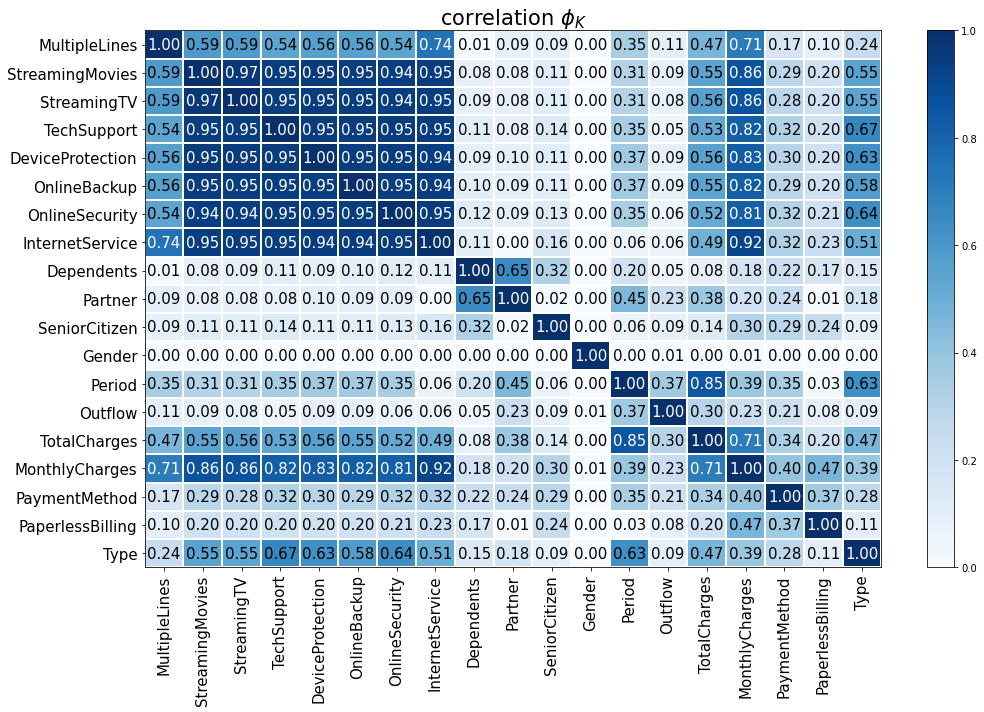

In [54]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,10))
plt.tight_layout()

по матрице мы можем увидеть, что сильной корреляции подвержены многие пары признаков, однако исключить их все невозможно, т.к. в некоторых присутвует важная информация о клиентах. остановимся на следующих: 
1. после EDA мы выделили несколько пар с походими распределениями, удалим по одному из признаков в каждой паре

2. так же можно удалить 'Gender' т.к. у него минимальная или нулевая корреляция со всеми признаками, так же как и с целевым 

In [55]:
data = Outflow_df_drop.drop(['TechSupport','DeviceProtection','StreamingMovies', 
                             'Gender','StreamingTV','OnlineBackup','OnlineSecurity',
                             'InternetService','TotalCharges'], axis=1)

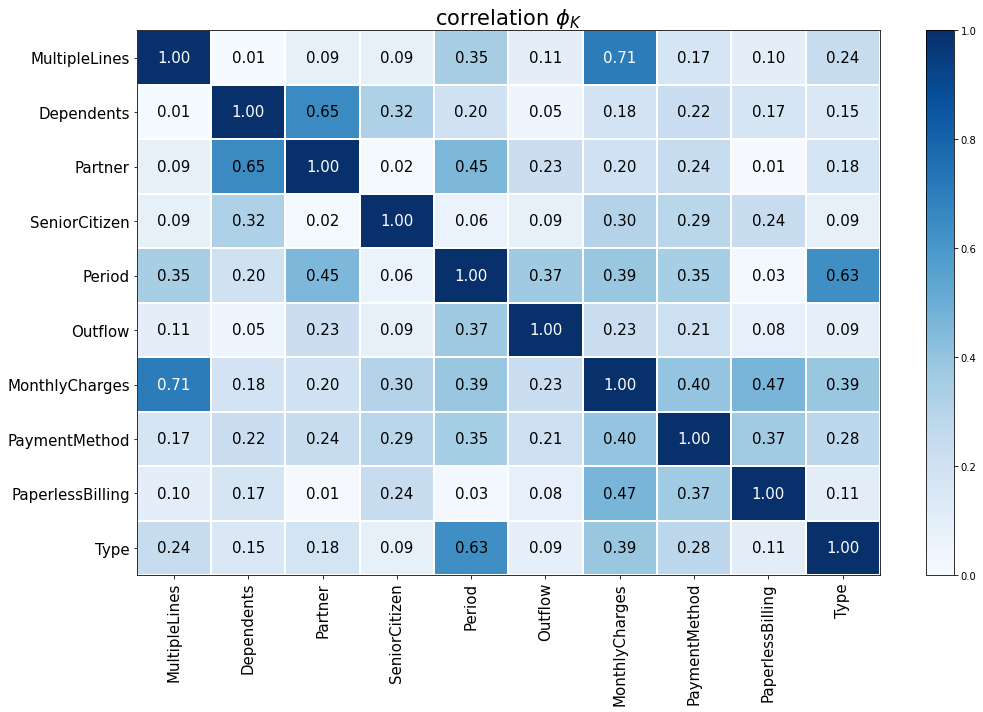

In [56]:
phik_overview = data.phik_matrix(interval_cols = interval_cols)

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(15,10))
plt.tight_layout()

признаков с сильной корреляцией осталось много, однако будем считать это компромиссом

In [57]:
interval_cols = ['MonthlyCharges','Period']

## оценка и балансировка классов

посмотрим на балансировку целевого признака 

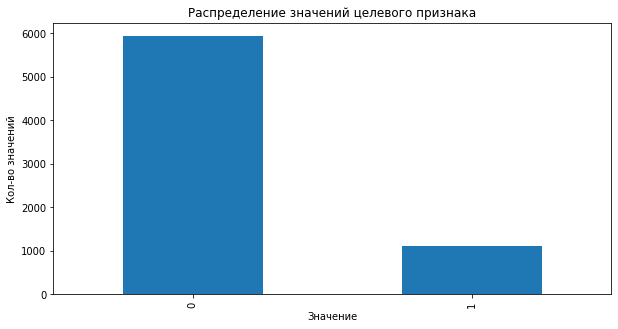

In [58]:
data['Outflow'].value_counts().plot(
    kind='bar', 
    figsize=(10, 5), 
    legend=False, 
    title='Распределение значений целевого признака', 
).set(xlabel='Значение', ylabel='Кол-во значений')
plt.show()

Заметен явный дисбаланс классов, однако наша основная метрика AUC-ROC не чувствительна к дисбалансу, да и в задачах подобного типа дисбаланс представлен куда ярче и сильнее, так что, оставим значение в таком же виде  

важно понимать, что в данном случае перед нами не проблема дисбаланса, а нормальное распределение класов, тем более если учитывать нашу метрику 

### кодировка признаков 

In [59]:
features = data.drop(['Outflow'], axis=1)
target = data['Outflow']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=random_state)

print(features_train.shape[0])
features_test.shape[0]


5282


1761

In [60]:
cat_cols = ['Type','PaperlessBilling','PaymentMethod','SeniorCitizen','Partner','Dependents','MultipleLines']

с помощью Pipeline трансформируем данные 

In [61]:
num_pipeline = Pipeline(steps=[('scale',StandardScaler())])

cat_pipeline = Pipeline(steps=[('one-hot',OneHotEncoder(drop='first',handle_unknown = 'error'))])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,interval_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

### LogisticRegression

создадим Pipeline для LogisticRegression

In [62]:

pipe = Pipeline([
    ('col_trans', col_trans),
    ('estimator', LogisticRegression(verbose=0, random_state= random_state, max_iter = 1000)),
]);

In [63]:
param_distributions = {
        'estimator__n_jobs': optuna.distributions.CategoricalDistribution([-1]),
        'estimator__penalty': optuna.distributions.CategoricalDistribution(['l2']),
        'estimator__solver': optuna.distributions.CategoricalDistribution(['saga','lbfgs']),
        'estimator__C': optuna.distributions.FloatDistribution(50,101,50)#, 1e2)
        }

In [64]:


opt_search = optuna.integration.OptunaSearchCV(pipe, param_distributions, cv = 5,
                                                n_trials=500, scoring='roc_auc')
opt_search.fit(features_train, target_train)


OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('col_trans',
                                          ColumnTransformer(n_jobs=-1,
                                                            transformers=[('num_pipeline',
                                                                           Pipeline(steps=[('scale',
                                                                                            StandardScaler())]),
                                                                           ['MonthlyCharges',
                                                                            'Period']),
                                                                          ('cat_pipeline',
                                                                           Pipeline(steps=[('one-hot',
                                                                                            OneHotEncoder(drop='first'))]),
                                                

In [65]:
print("Количество запусков: {}".format(len(opt_search.study_.trials)))
print("Лучший результат:")
trial = opt_search.study_.best_trial
print("  метрика: {}".format(trial.value))
parameters = opt_search.best_params_
print(parameters)

Количество запусков: 500
Лучший результат:
  метрика: 0.7368601331039809
{'estimator__n_jobs': -1, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs', 'estimator__C': 53.352594313919035}


### CatBoostClassifier

In [66]:
train_pool = Pool(features_train, target_train, cat_features=cat_cols)

In [67]:
def objective(trial):

    global train_pool

    params = {
        'n_estimators': trial.suggest_int("n_estimators", 250, 500),
        'max_depth': trial.suggest_int("max_depth", 2, 4),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 2.5, 4),
        'random_strength': trial.suggest_float("random_strength", 0.9, 1.4),
        "learning_rate": trial.suggest_float("eta", 1e-2, 1e-1, log=True),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 5),
        'grow_policy': trial.suggest_categorical('grow_policy', ['Lossguide']),
        'random_state': trial.suggest_categorical('random_state', [random_state]),
        "eval_metric": trial.suggest_categorical('eval_metric', ["AUC"]),
        "loss_function": trial.suggest_categorical('loss_function', ['Logloss']),
        'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
        }

    scores = cv(train_pool, params, fold_count=4)

    return scores['test-AUC-mean'].values[-1]

In [68]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective, n_trials=1e6, timeout=60*1)

In [85]:
print("Количество запусков: {}".format(len(study_cat.trials)))

print("Лучший результат:")
cbc_trial = study_cat.best_trial
print("  ROC AUC: {}".format(cbc_trial.value))

cbc_trial = study_cat.best_trial
cbc_parameters = cbc_trial.params
print('Оптимальные параметры:', parameters)

Количество запусков: 5
Лучший результат:
  ROC AUC: 0.905123655526717
Оптимальные параметры: {'estimator__n_jobs': -1, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs', 'estimator__C': 53.352594313919035}


## оценка модели

проверяем CatBoostClassifier на тестовой выборке

In [109]:
model_cat = CatBoostClassifier(random_state=random_state,n_estimators=359, max_depth = 3,subsample=0.82,
                              l2_leaf_reg=3.7,random_strength = 1.01,eta = 0.06, min_data_in_leaf = 1,grow_policy='Lossguide')
model_cat.fit(features_train, target_train, cat_features=cat_cols, plot=False, verbose=False)
pred_proba = model_cat.predict_proba(features_test)[:, 1]
cbc_score = roc_auc_score(target_test, pred_proba)
cbc_score

0.9041538053438797

итоговый roc-auc получился 0.9, что устраивает нас


## анализ важности признаков

с помощью shap посмотрим на значимость признаков 

In [71]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(features_train)

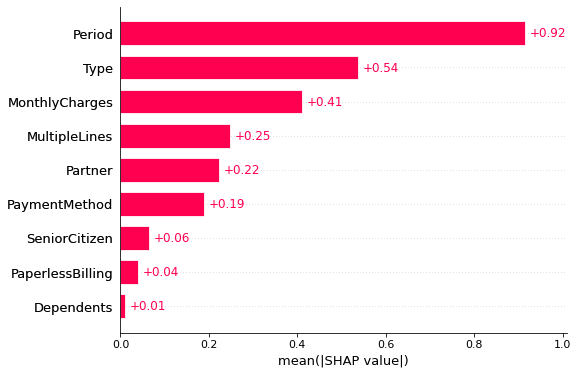

In [72]:
shap.plots.bar(explainer(features_train))

самыми важными признаками оказались period, Type, monthlychargers и totalcharges

давайте подробнее посмотрим влияение признаков

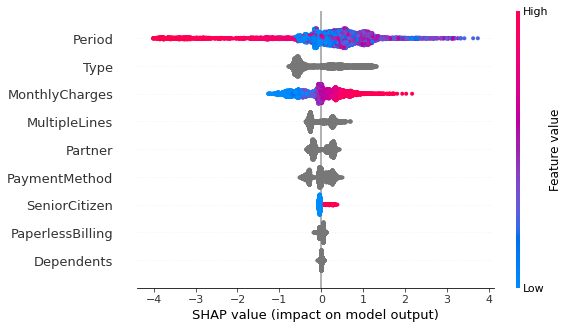

In [73]:
shap.plots.beeswarm(explainer(features_train))

по граффику можно явно заметить:
- чем больше в среднем в месяц клиент платит оператору, тем вероятность его ухода выше
- у period нет прямой зависимости, можно лишь заметить, что те кто пользуються оператором долгое время - предпочитают оставаться (но их не так много)

## матрица ошибок

ROC-AUC score 0.9041538053438797


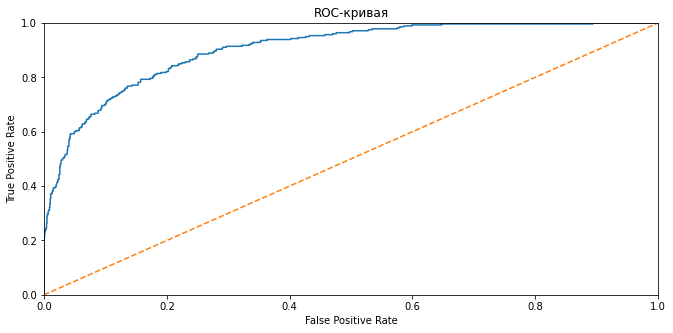

In [74]:
def plot_roc_curve(target_test, predictions):
    print('ROC-AUC score', roc_auc_score(target_test, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_test, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()
    
plot_roc_curve(target_test, pred_proba)    

In [75]:
pred = []
for x in pred_proba:
    if x > 0.4:
         pred.append(1)
    else:
        pred.append(0)

In [76]:
confusion_matrix(target_test, pred)

array([[1425,   56],
       [ 131,  149]])

при изучении ROC кривой, а так же матрицы ошибок, был выбран достаточно низкий порог классификации - 0.4:

1. так как нас интересуют ушедшие клиенты (а их в выбоке около 15%), то мы обращаем внимание на нижнюю строчку матрици 
- нижнее правое значение - это верно угаданные моделью ушедшие клиенты
- нижнее левое значение - ушедшие клиенты, которых модель не смогла угадать
- нам важно определить как можно лучше ушедших клиентов, поэтому модель с пороговым значением в 0.4 - совершает больше ошибок в определении 0 класса, выставляя некоторым клиентам 1 класс (верхний правый угол - 56), однако лучше определяет тех кто дейсвительно ушел 


In [90]:
accuracy_cbc = accuracy_score(target_test, pred)
accuracy_cbc

0.8938103350369109

финальный accuracy на тестовой выборке составляет 0.89 

Accuracy — это показатель, который описывает общую точность предсказания модели по всем классам. 

в нашем случае, беруться правильно угаданные моделью единицы данных и деляться на общее число единиц данных

In [78]:
(1425+149)/(1425+149+131+56)

0.8938103350369109

однако стоит отметить, что данная метрика не совсем объективно отражает точность модели: при условии дисбаланса, данная метрика плохо учитывает точность по каждому классу

## Общий вывод:

### ключивые шаги работы над проектом

В ходе роботы был выполнено:
    
1. предварительный анализ данных 
2. подготовка данных: 
- выделение целевого признака: признак "Outflow"
- приведение данных к нужному типу
- обработка пропусков
- объединение таблиц
2. EDA: 
- изучение признаков
- графический анализ 
3. предмодельная подготовка: 
- корреляционный анализ данных
- изучение балланса классов 
- кодировка признаков с помощью pipeline 
4. обучение моделей с помощью pipline и optuna: лучшей моделью была выбрана CatBoostClassifier
5. проверка модели на тестовой выборке: финальный `AUC-ROC = 0.9`
6. анализ важности признаков 
7. анализ матрицы ошибок 
8. расчет метрики Accuracy на тестовой выборке - 0.89


### анализ соотвесвия фактичекой работы запланированным шагам 

1. в запланированном плане было 6 основных пунктов, в каждом из которыз было от 2 до 5 подпунктов 
2. в реальном проекте все основные пункты были соблюдены в четком соотвесвии, подпункты несколько раз могли меняться местами, дополняя друг друга. Основная "незапланированная" работа пришлась на обработку признаков: 

- корреляционный анализ приходилось смотреть несколько раз после удаление лишних признаков
- на этапе EDA приходилось дорабатывать тип данных в признаках 
- после попыток обучения моделей так же приходилось возвращаться и дополнительно обрабатывать признаки 

### Итоговый список признаков

в финальный список признаков, на которых обучались модели, попали: 
    
    1. Интервальные 
    - MonthlyCharges - среднемесячная сумма трат клиента на услуги
    
    - Period - кол-во дней пользования услугами оператора клиентами 
    данный признак был составлен по удаленным из финального списка признакам BeginDate EndDate - путем вычитания из дады окончания пользования услугами даты начала пользования. Данный признак оказался одним из значимых 
    
    все интервальные данные были стандартизированы перед обучение линейной регрессии, остальных изминений с ними не проводили
    
    2. Категориальные признаки
    
    - Type - тип оплаты подписки, включает 3 категории "ежемесячно", " раз в год", "раз в два года"
    - PaperlessBilling - наличие платежного документа, включает 2 категории "yes" и "no"
    - PaymentMethod - метод оплаты, включает в себя 4 категории:
      "кредитная карта", "майл чек", "автоматический банковский перевод" и "електронный чек" 
    - SeniorCitizen - наличие пенсионного статуса, 2 категории: "1" и "0" где 1 означает наличие пенсионного статуса
    - Partner -  наличие партнера, 2 категории: "yes" и "no" 
    - Dependents - наличие иждевенца, 2 категории: "yes" и "no" 
    - MultipleLines - наличие возможности ведения параллельных линий во время звонка, 3 категории:"yes","no" и "Notused".             третья категория была выделена отдельно для доп услуг, что бы не перемешивать выборку между теми кто пользуется основными 
      услугами (телефония и интернет) но не пользуется доп услугами 
      
      перед обучением линейной регрессии категориальные признаки были обработаны с помощью техники OHE для преобразования             категориальных переменных в формат, который может быть легко использован алгоритмами машинного обучения.
      
      

### предобработка данных

были изучены 4 имеющихся баз данных: contract, personal, internet, phone. Были произведены: 

- проверка на дубликаты 
- заполнение пропуков
- объединение данных 
- изминение наименований признаков 
- приведение признаков к нужному типу
- создание нового признака period


### исследовательские модели

In [87]:
data_final = {'Название модели': ['LogisticRegression', 'CatBoostClassifier'],
        'ROC-AUC на кросс-валидации': [format(trial.value), format(cbc_trial.value)]
        }
df = pd.DataFrame(data_final)
df

,Название модели,ROC-AUC на кросс-валидации
0,LogisticRegression,0.7368601331039809
1,CatBoostClassifier,0.905123655526717


### Лучшая модель 

лучшей моделью себя показала CatBoostClassifier

In [88]:

print("Лучший результат:")
cbc_trial = study_cat.best_trial
print("  ROC AUC: {}".format(cbc_trial.value))

cbc_trial = study_cat.best_trial
cbc_parameters = cbc_trial.params
print('Оптимальные параметры:', parameters)

Лучший результат:
  ROC AUC: 0.905123655526717
Оптимальные параметры: {'estimator__n_jobs': -1, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs', 'estimator__C': 53.352594313919035}


### Итоговая метрика 

In [92]:
df_cbc = pd.DataFrame({'Название модели': ['CatBoostClassifier'],
        'ROC-AUC на тестовой выборке': [cbc_score],
        'Accuracy': [accuracy_cbc]
        })
df_cbc

,Название модели,ROC-AUC на тестовой выборке,Accuracy
0,CatBoostClassifier,0.904154,0.89381


### Матрица ошибок

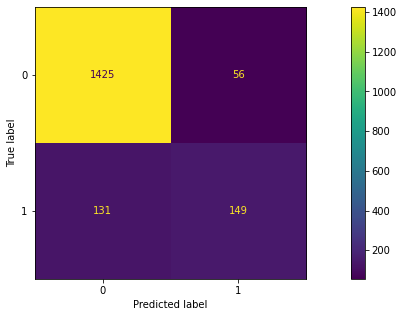

In [100]:
cm = confusion_matrix(target_test, pred, labels=model_cat.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_cat.classes_)

disp.plot()

plt.show()

при изучении матрицы ошибок, был выбран достаточно низкий порог классификации - 0.4. Что это значит?

1. так как нас интересуют ушедшие клиенты (а их в выбоке около 15%), то мы обращаем внимание на нижнюю строчку матрици 
- нижнее правое значение - это верно угаданные моделью ушедшие клиенты
- нижнее левое значение - ушедшие клиенты, которых модель не смогла угадать
- нам важно определить как можно лучше ушедших клиентов, поэтому модель с пороговым значением в 0.4 - совершает больше ошибок в определении 0 класса, выставляя некоторым клиентам 1 класс (верхний правый угол - 56), однако лучше определяет тех кто дейсвительно ушел 
- однако не стоит опускать порог еще ниже, т.к. значение ошибок в верхнем правом углу резко возрастает 

### Важность признаков

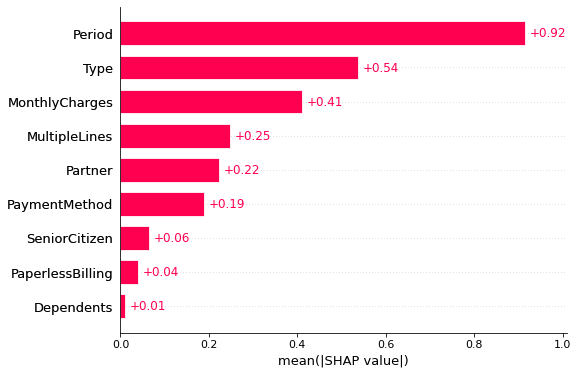

In [101]:
explainer = shap.TreeExplainer(model_cat)
shap_values = explainer.shap_values(features_train)

shap.plots.bar(explainer(features_train))

данный график показывает, на сколько значим тот или иной признак на целевое признак:

- самыми важными признаками оказались period, Type, monthlychargers и totalcharges
- по визуализации сложно сказать, в какую сторону работает сила того или иного признака: он может работать как на уход, так и на продолжение взаимодейсвия клиента с оператором


давайте подробнее посмотрим влияение признаков 

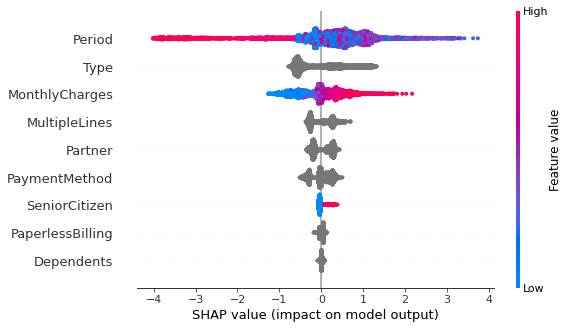

In [102]:
shap.plots.beeswarm(explainer(features_train))

1. значения слева от центральной вертикальной линии — это negative-класс (0), справа — positive (1) по матрице ошибок предиктивной ML-модели;
2. толщина линии прямо пропорциональна количеству точек наблюдения;
3. чем краснее точки, тем большее значение имеет признак в этой точке.

по граффику можно заметить:
- чем больше в среднем в месяц клиент платит оператору, тем вероятность его ухода выше
- у period нет прямой зависимости, можно лишь заметить, что те кто пользуються оператором долгое время - предпочитают оставаться (но их не так много)
- среди ушедших клиентов много людей со средним значением Period (если обращаться к EDA, это в районе 1000-2000 дней) 